## Loading of Miller ECoG data of the joystick track task

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [12]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][3]

print(dat.keys())

#print(dat.locs())

dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers:

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme:

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick
* `dat['cursorY']`: X position of the cursor controlled by the joystick
* `dat['locs`]: three-dimensional coordinates of the electrodes

In [13]:
dat['V'].shape
#dat['locs'].shape

(259920, 48)

In [14]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [10]:
# compute correlations between voltage data and X/Y position of cursor
from scipy import signal
dat = alldat[0][3]
V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

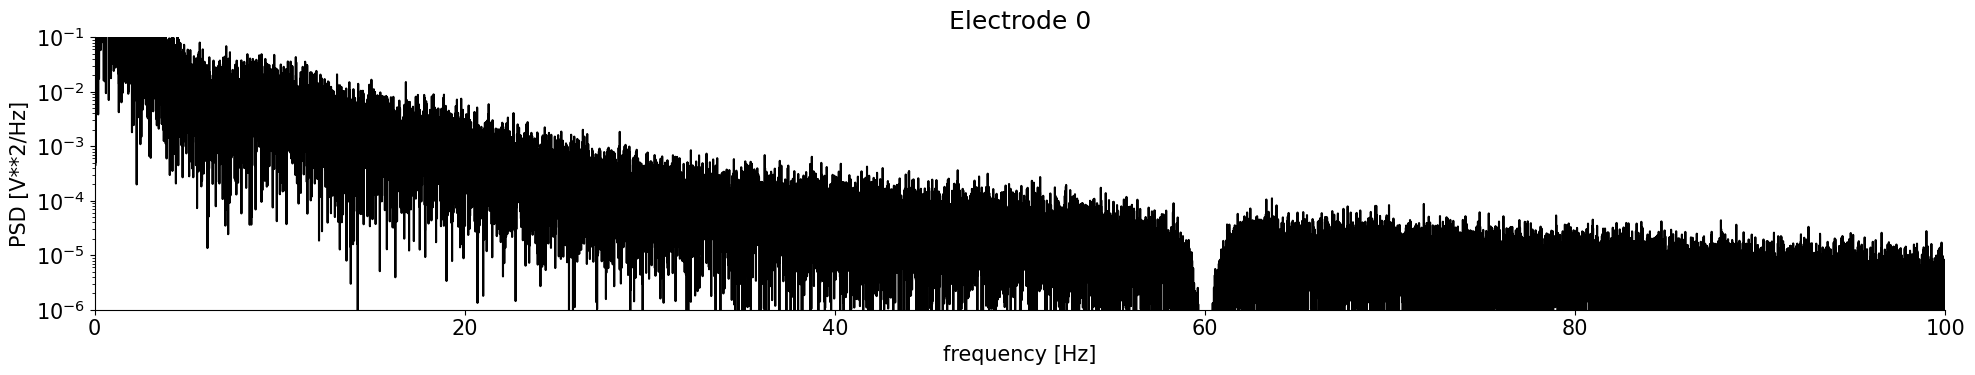

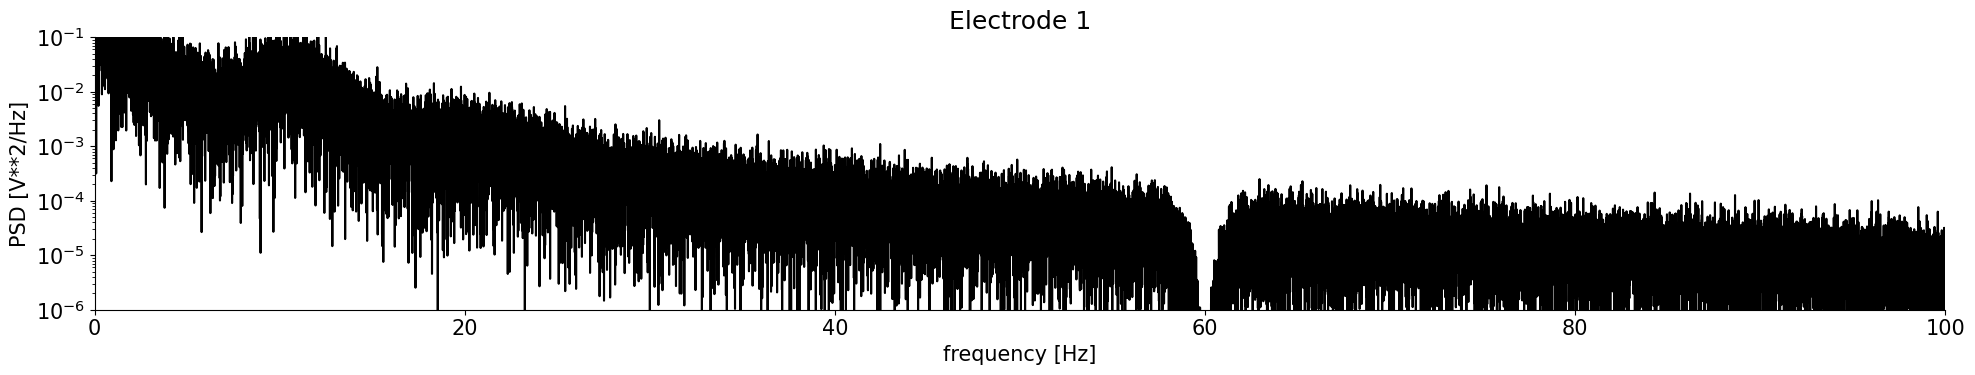

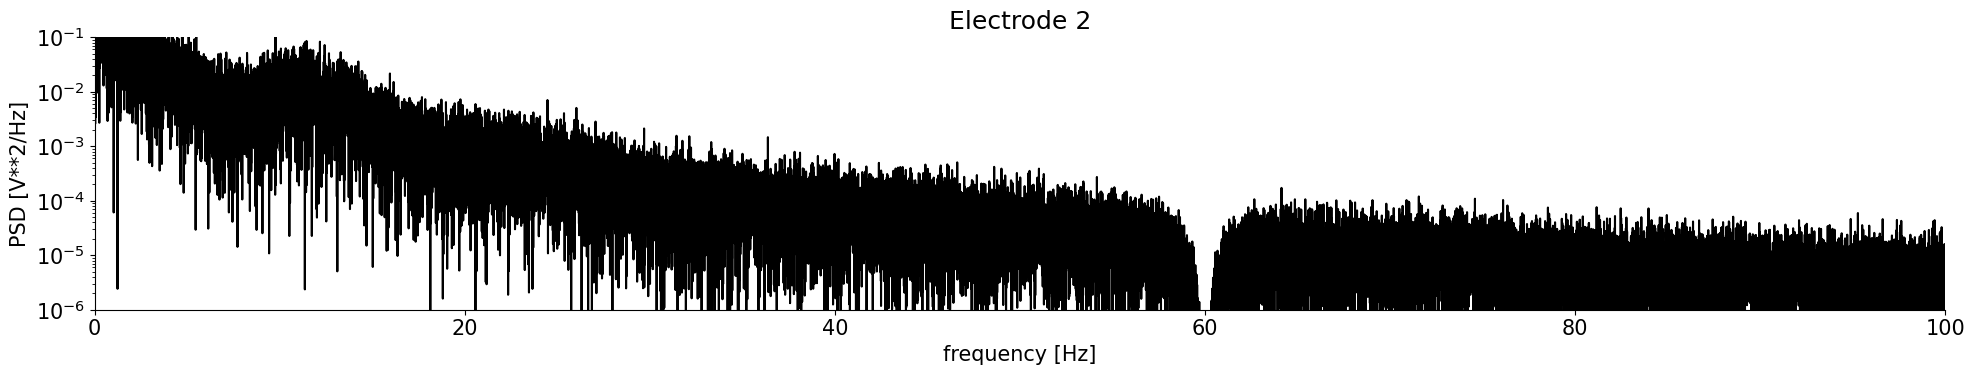

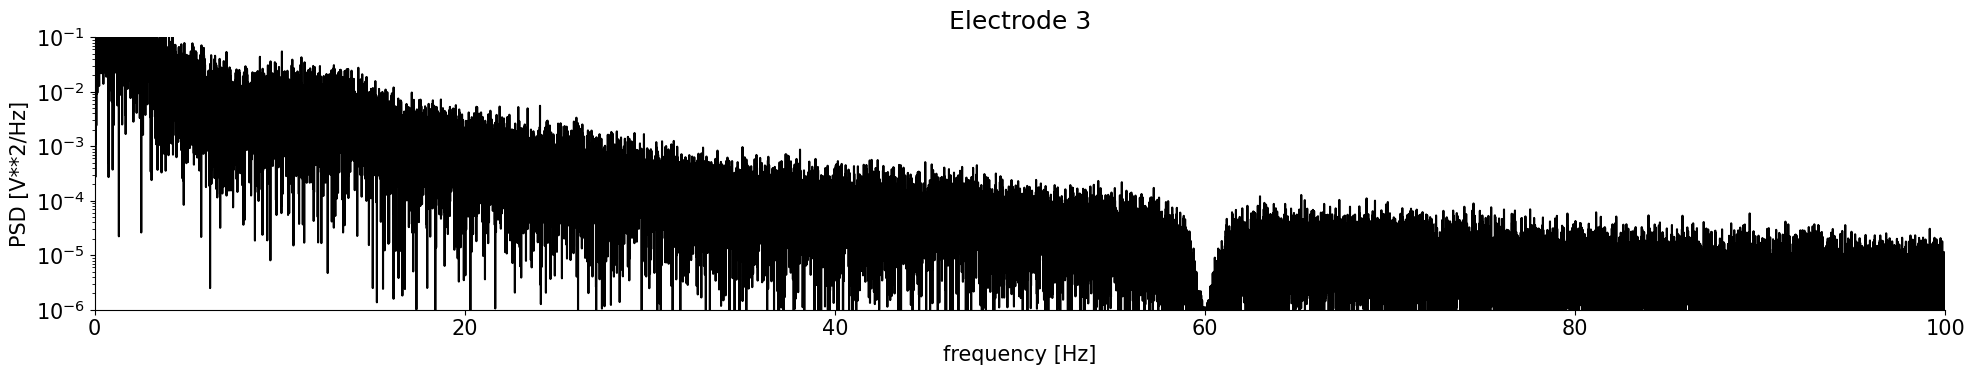

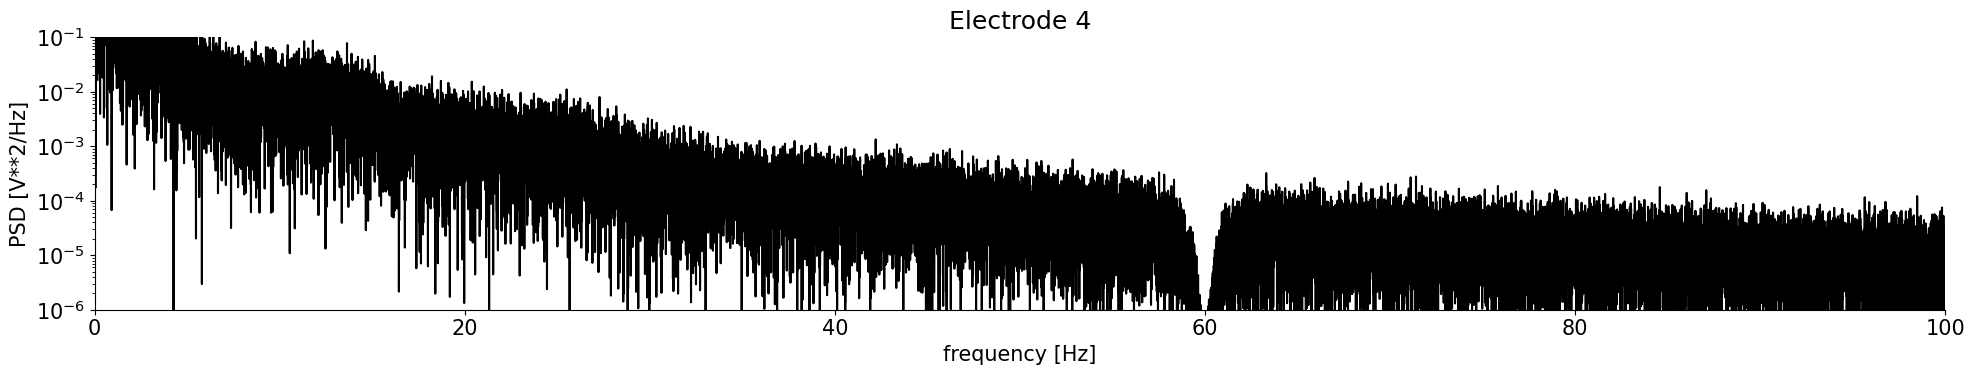

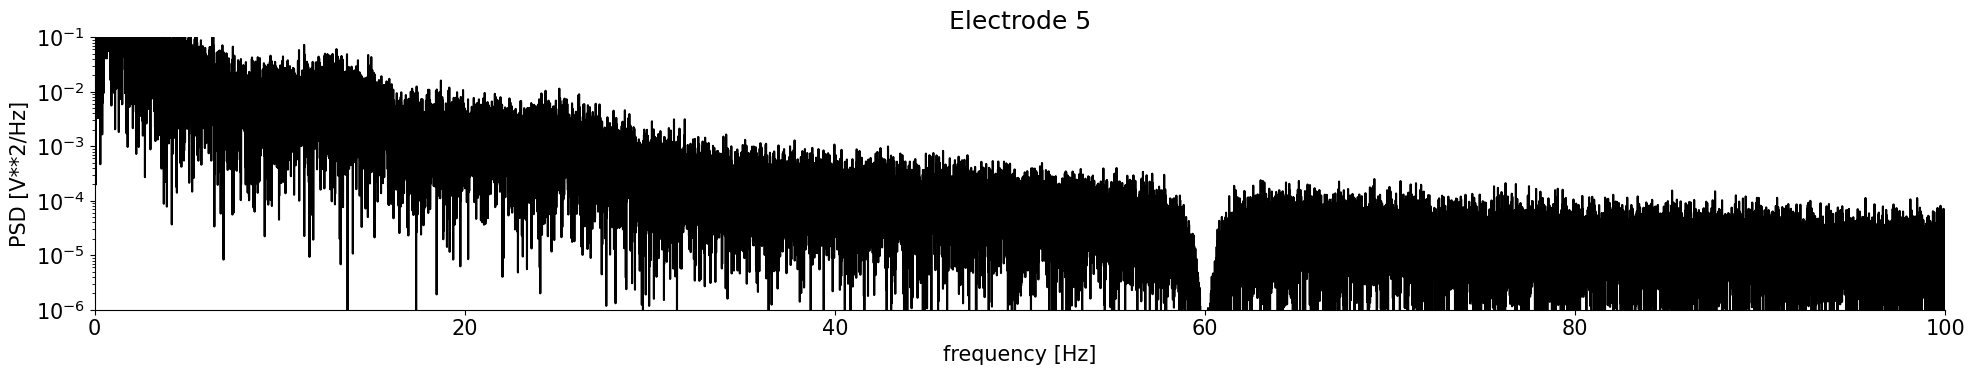

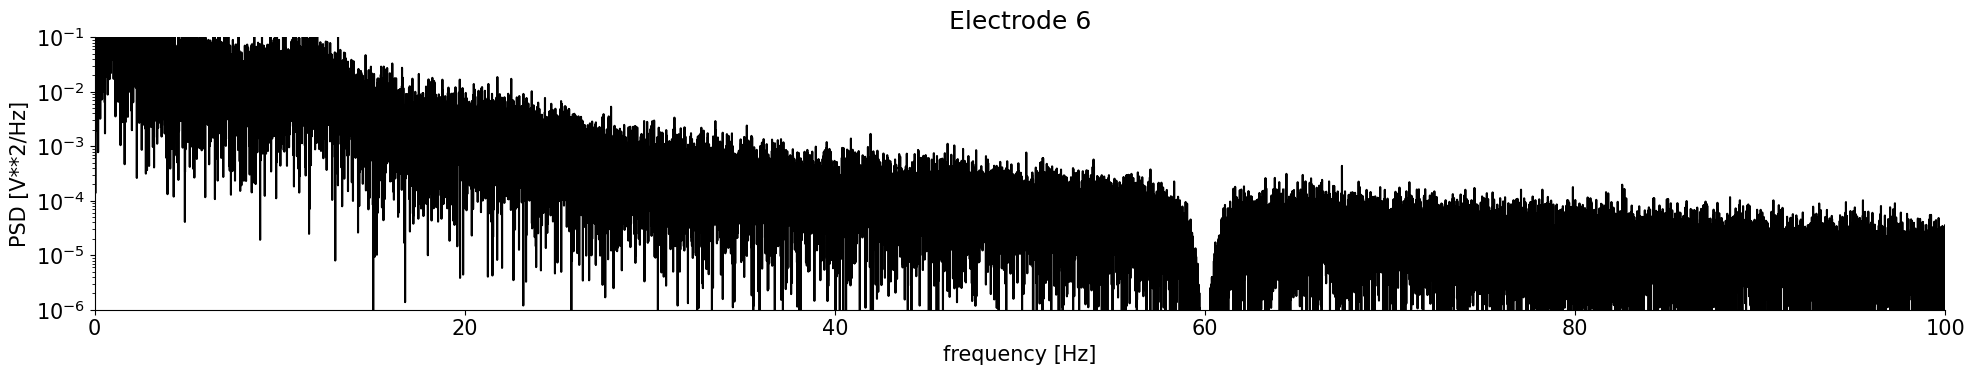

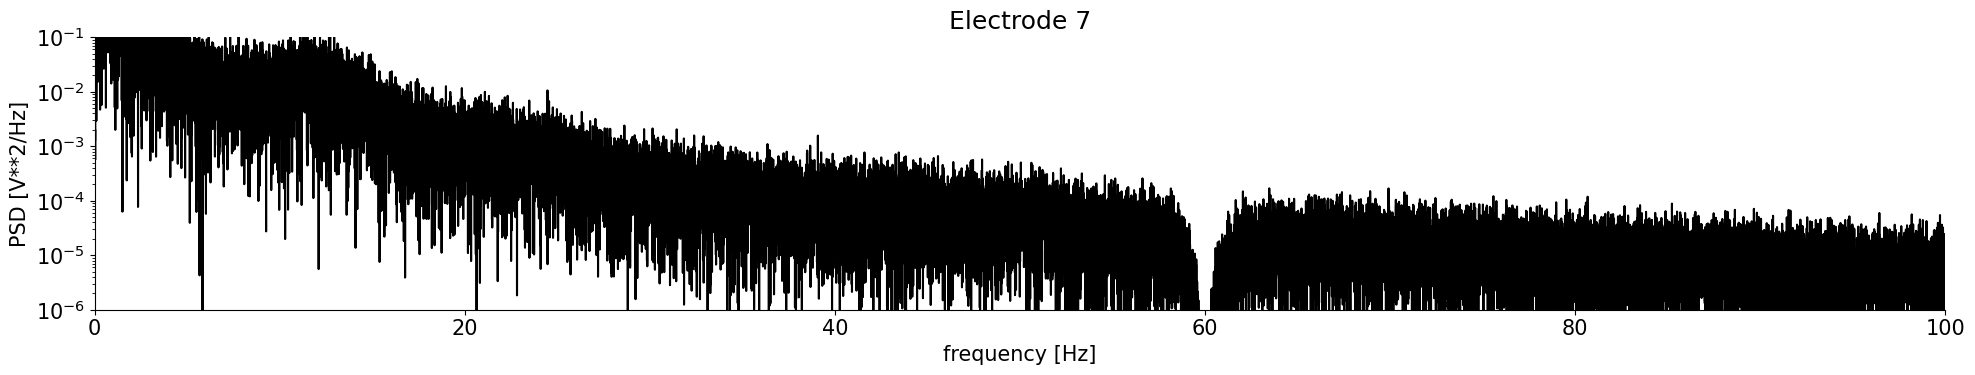

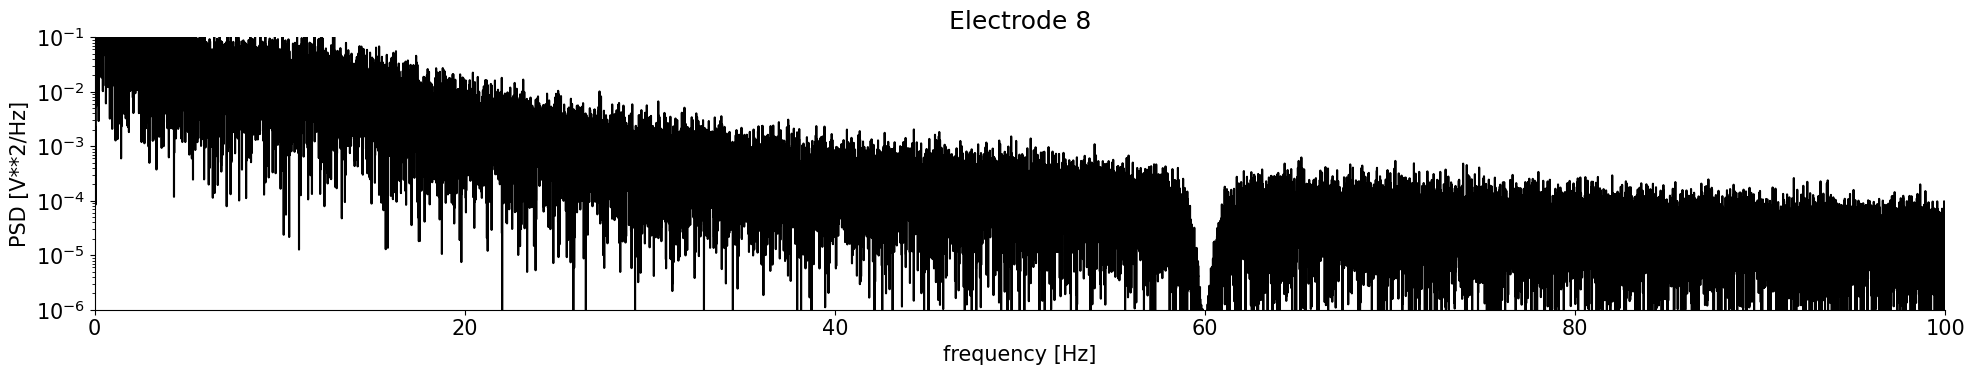

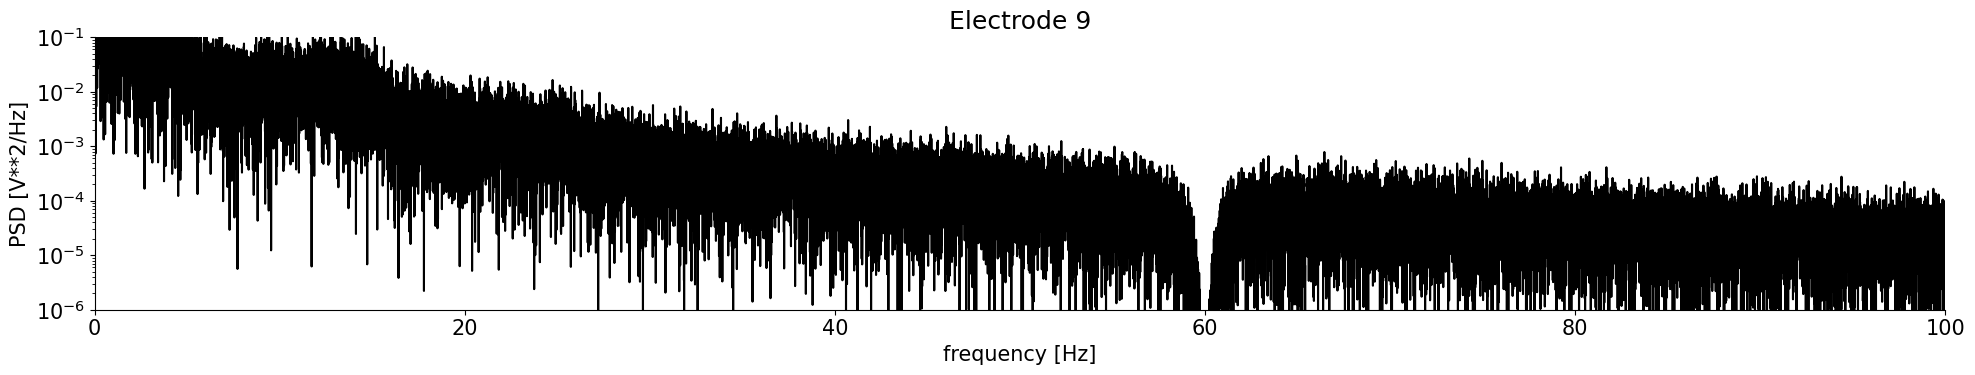

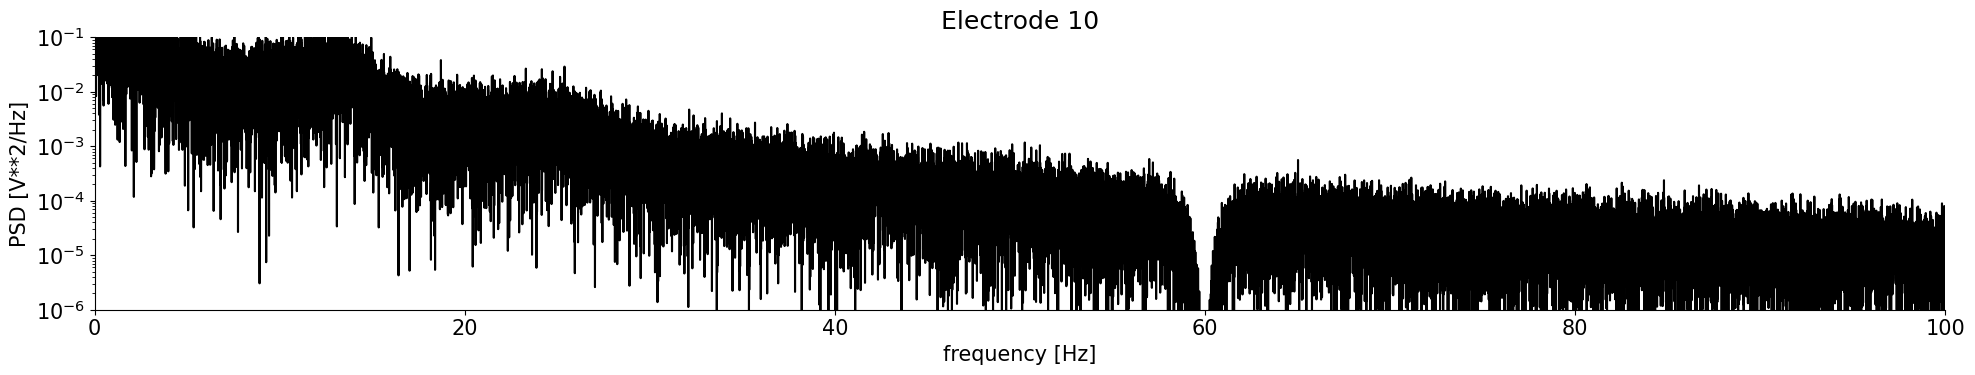

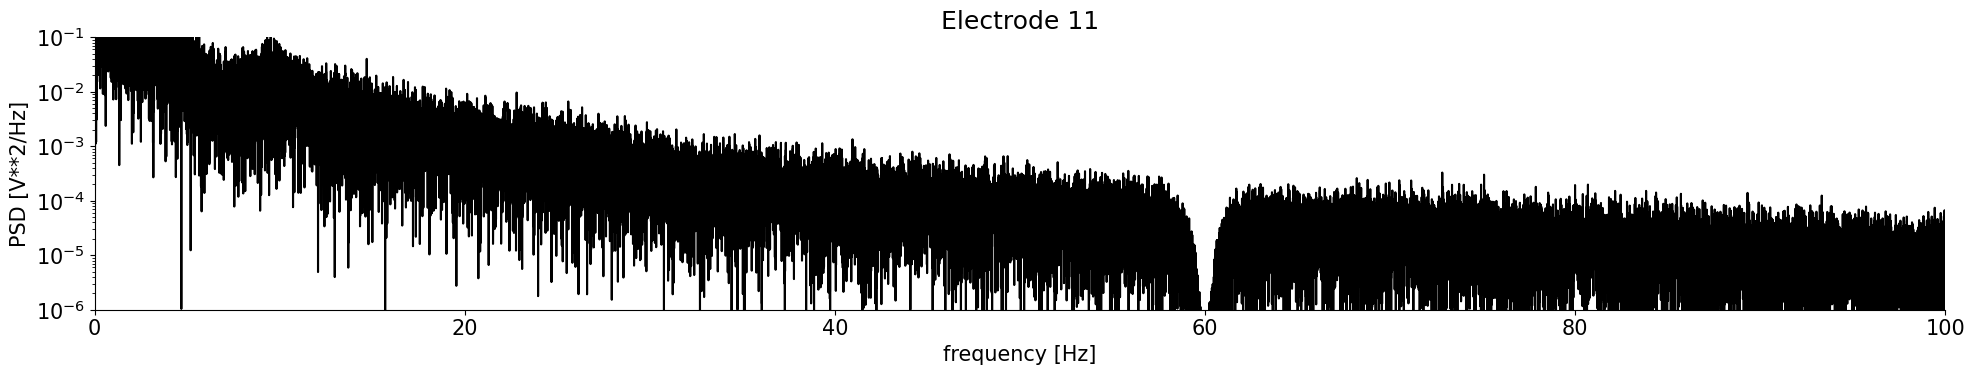

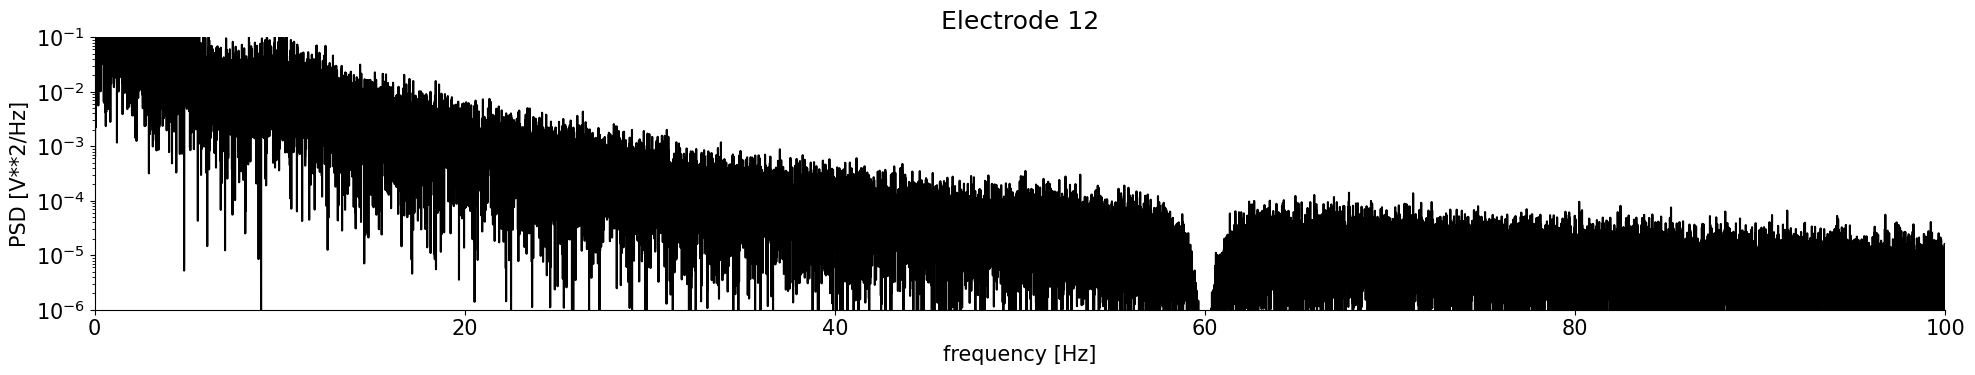

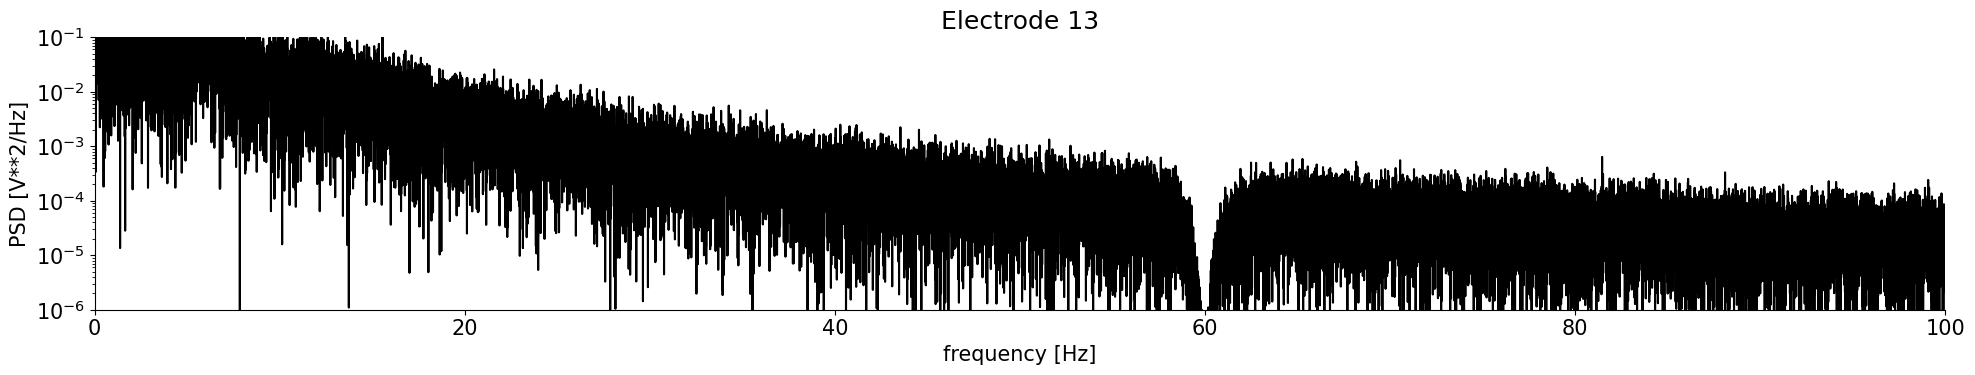

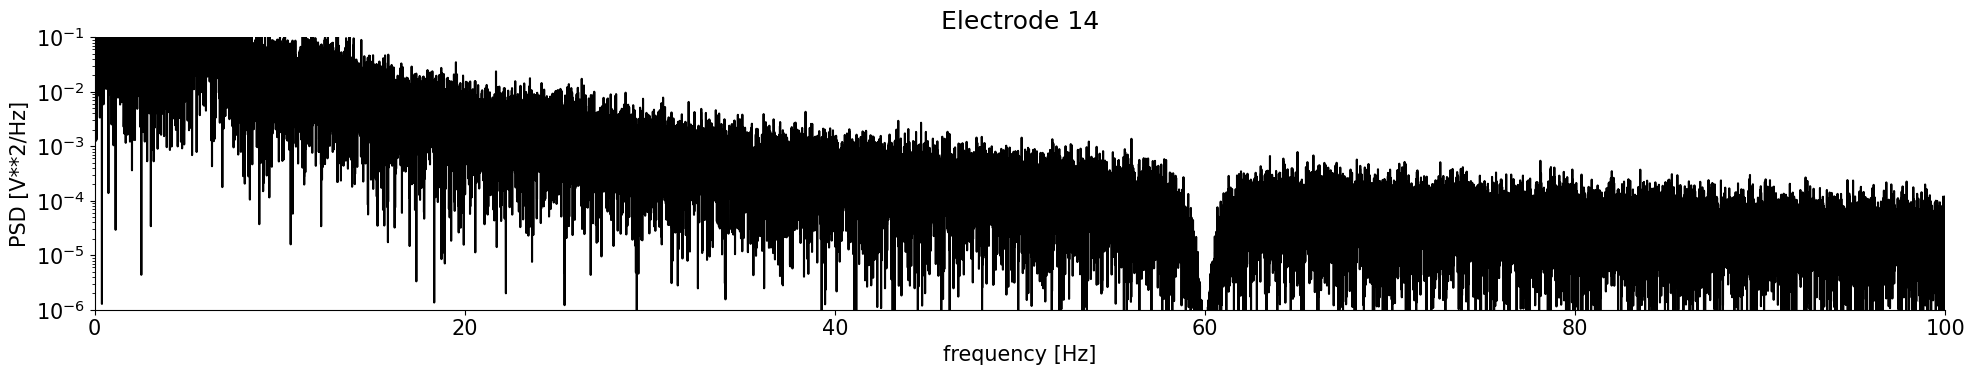

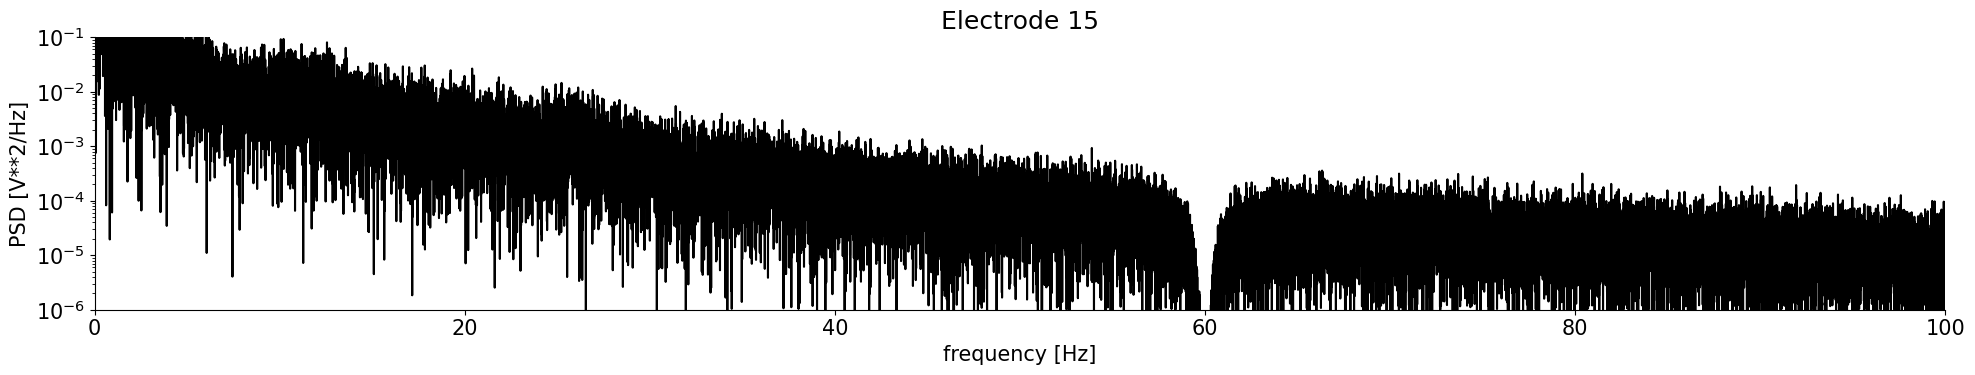

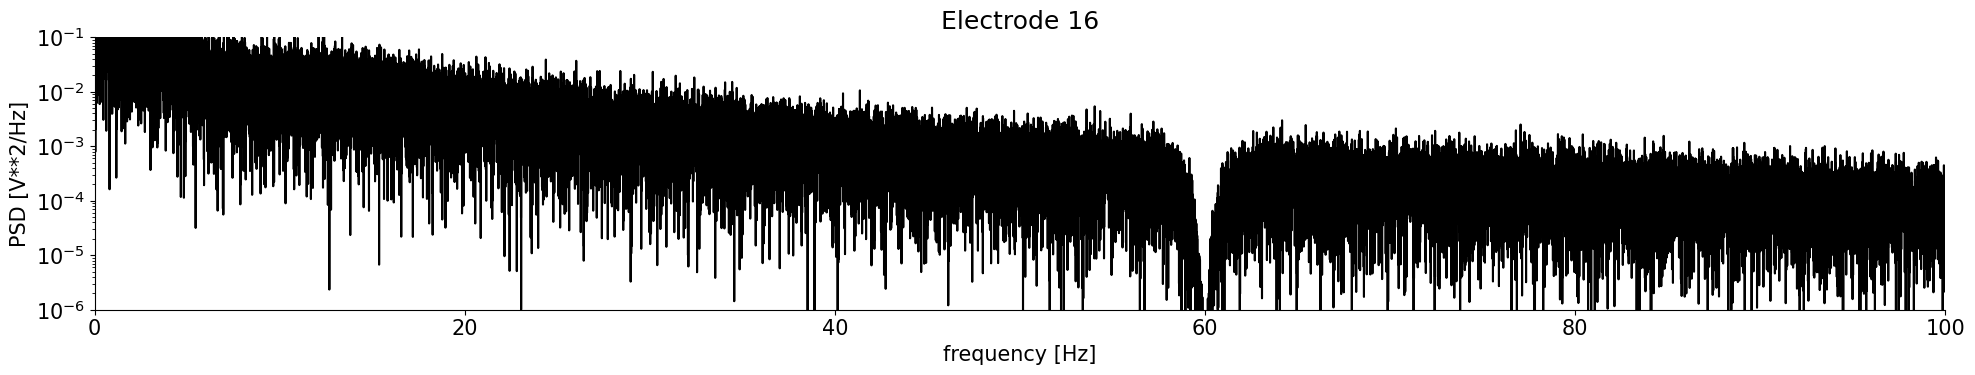

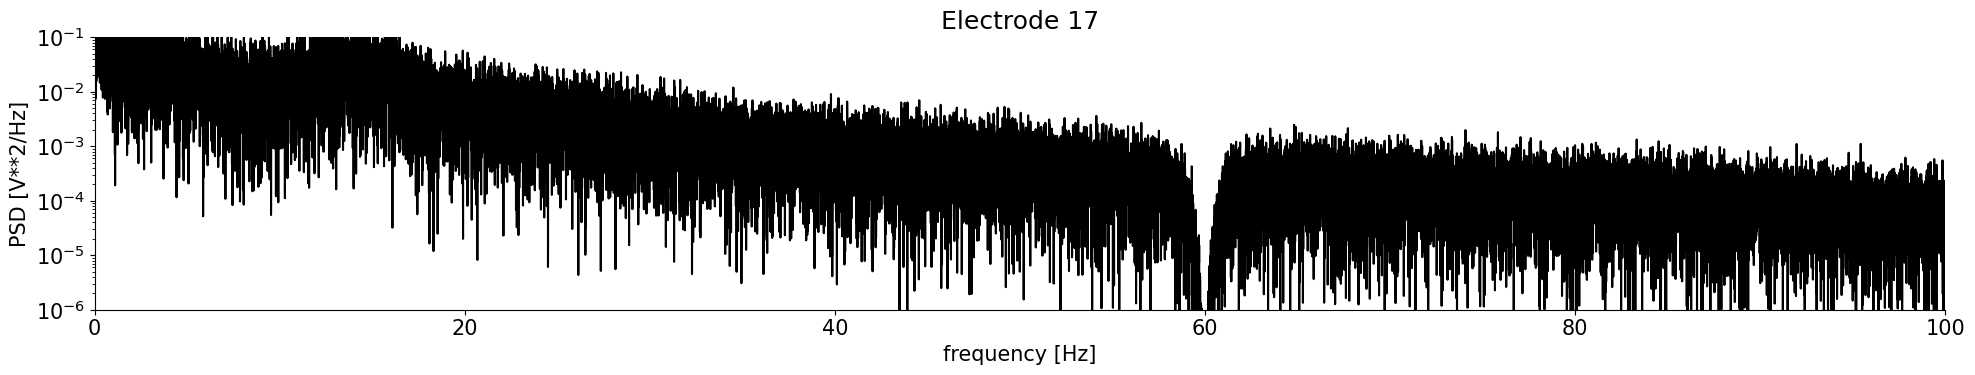

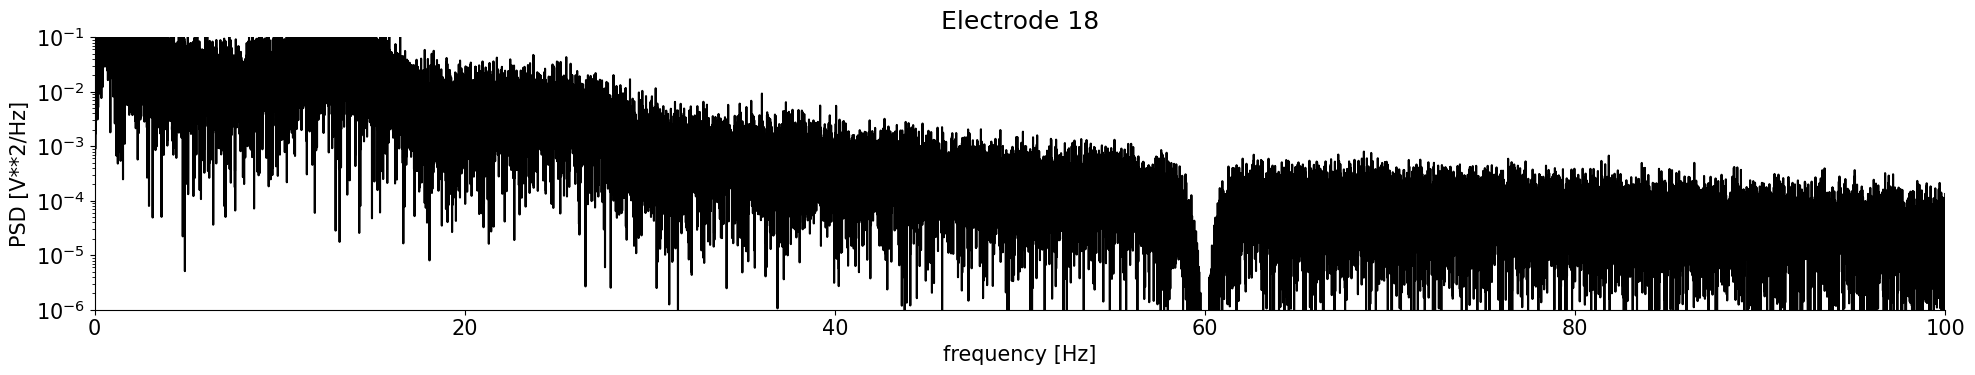

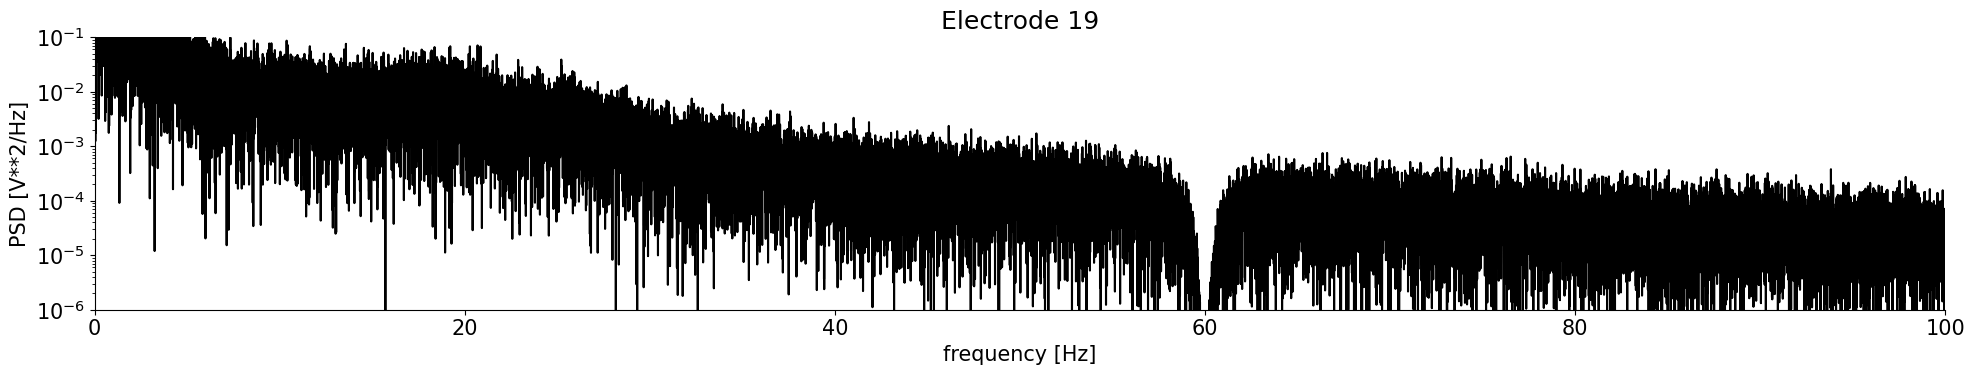

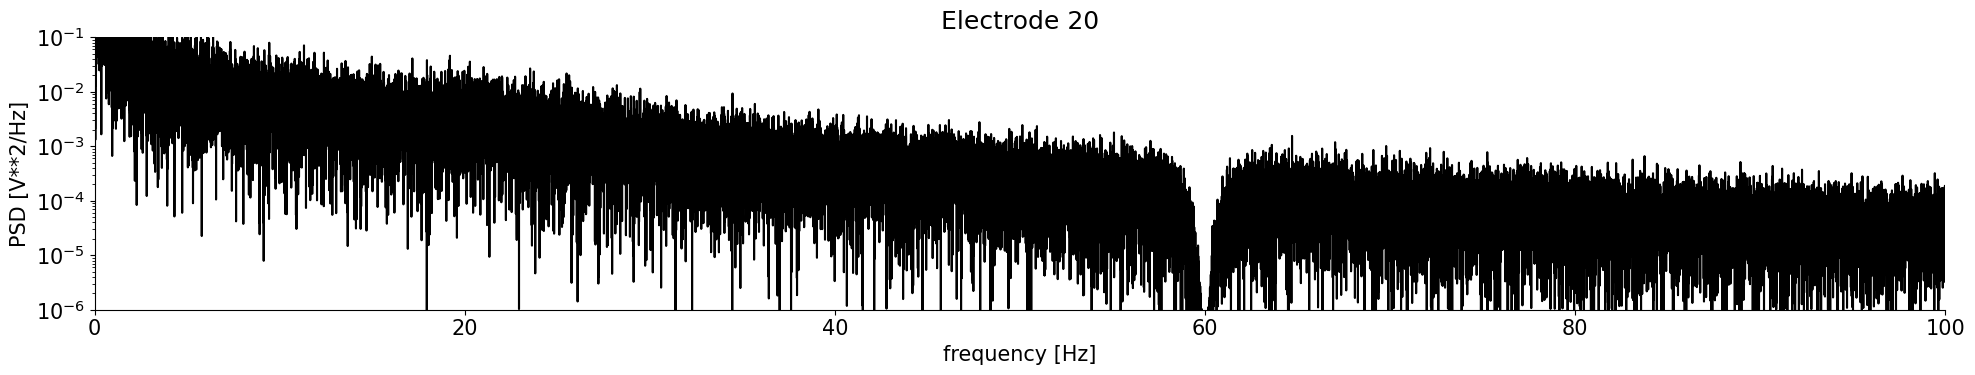

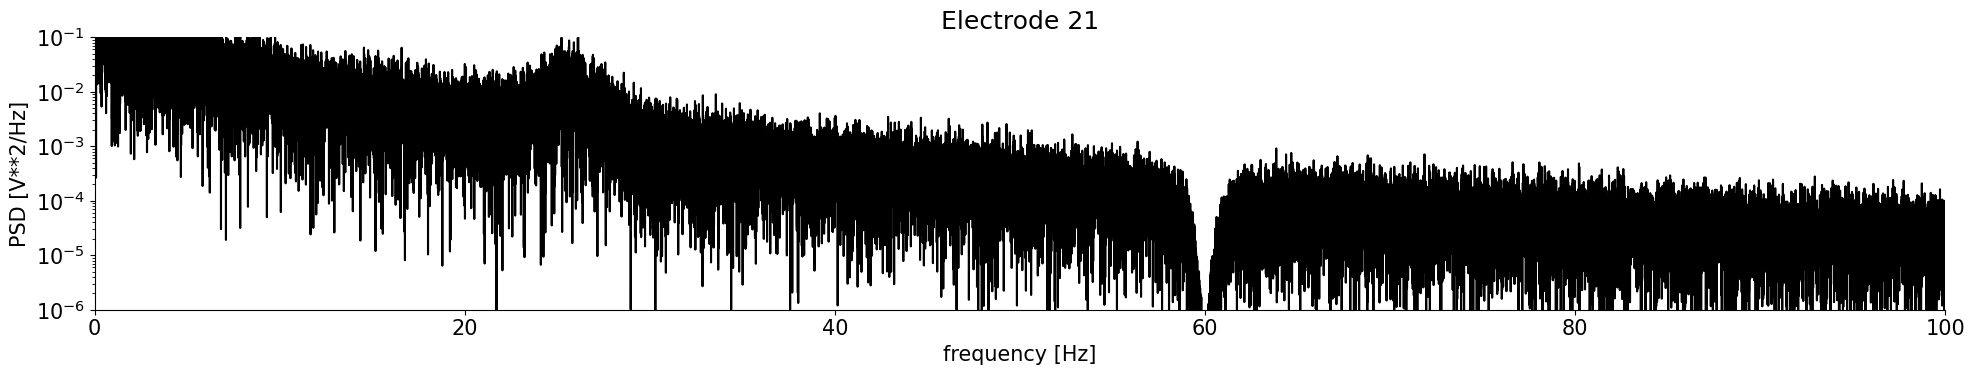

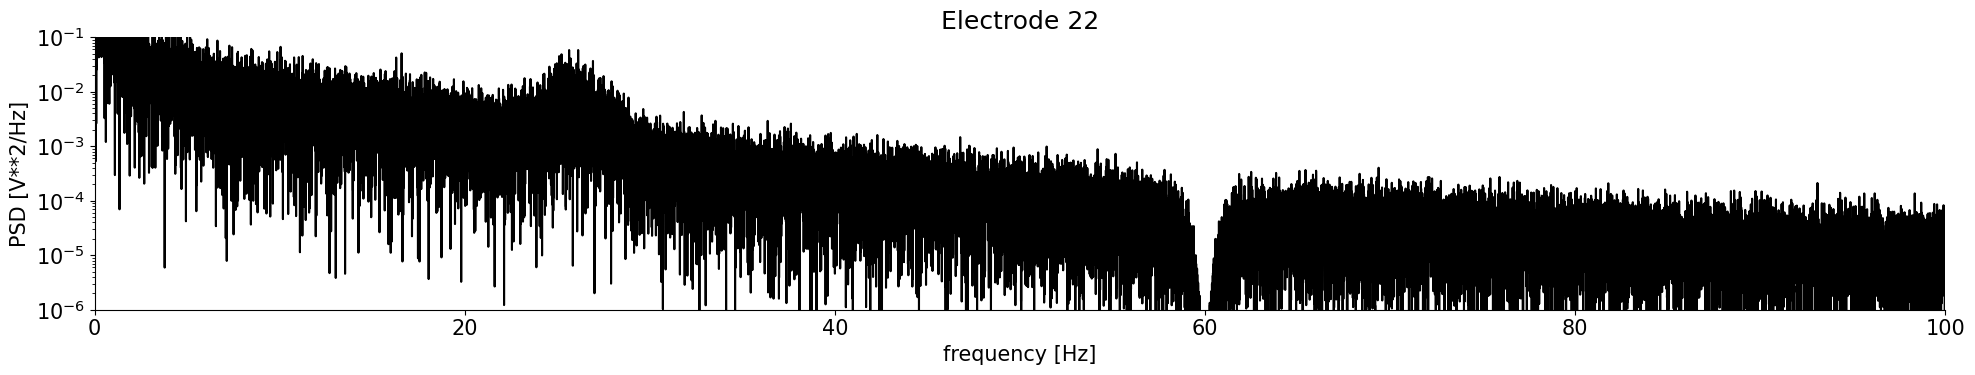

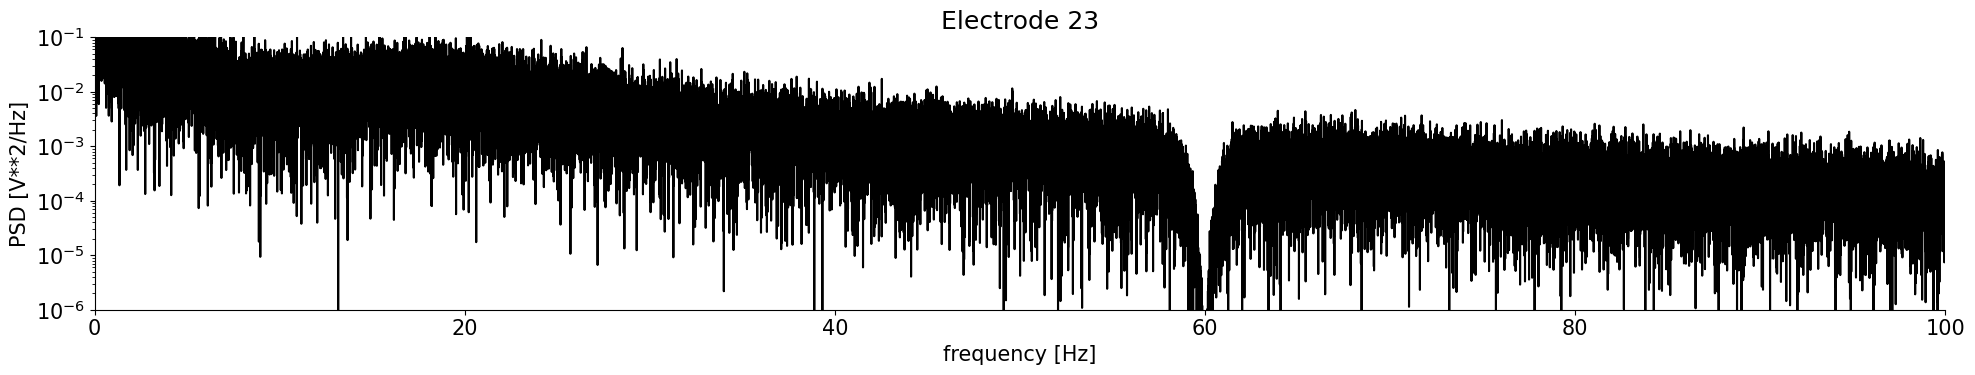

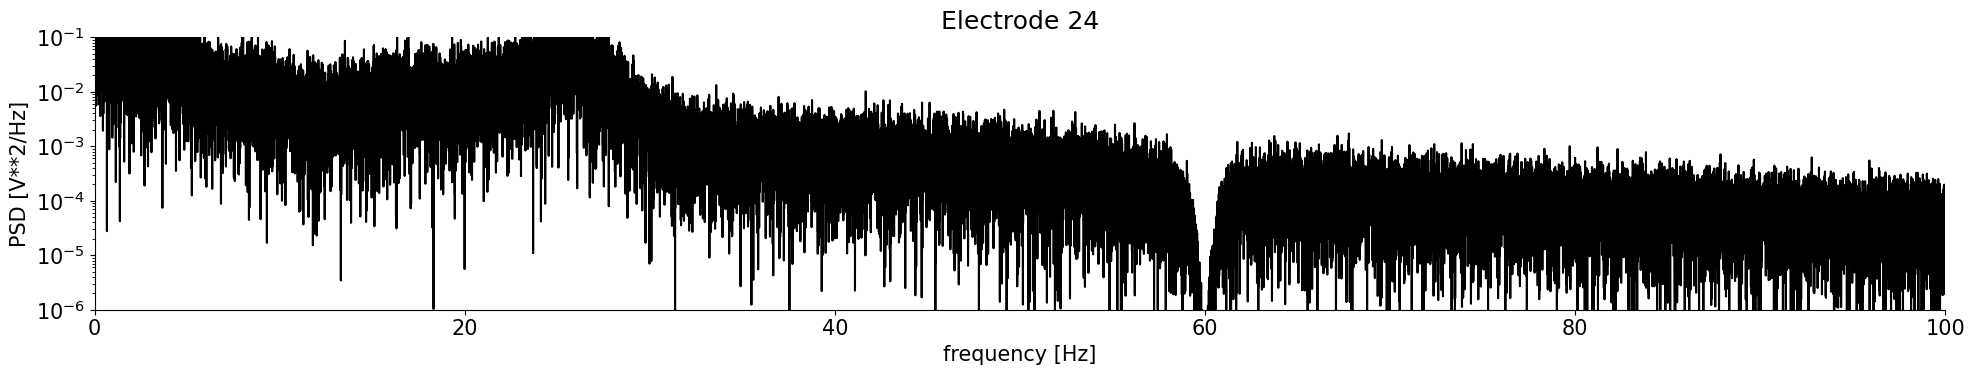

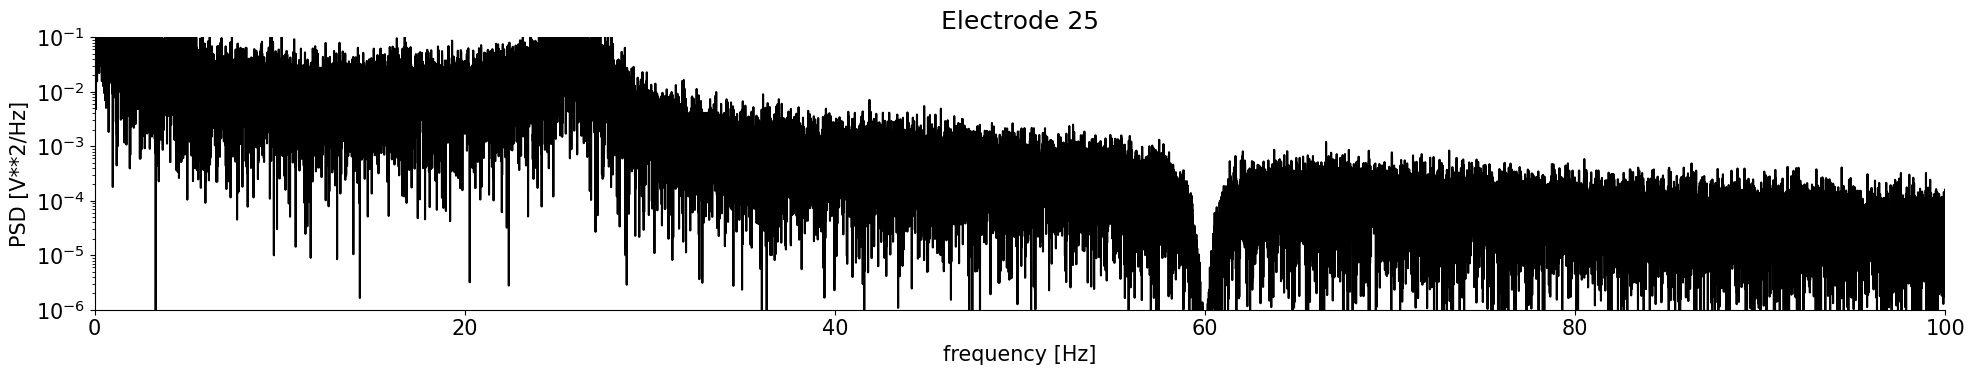

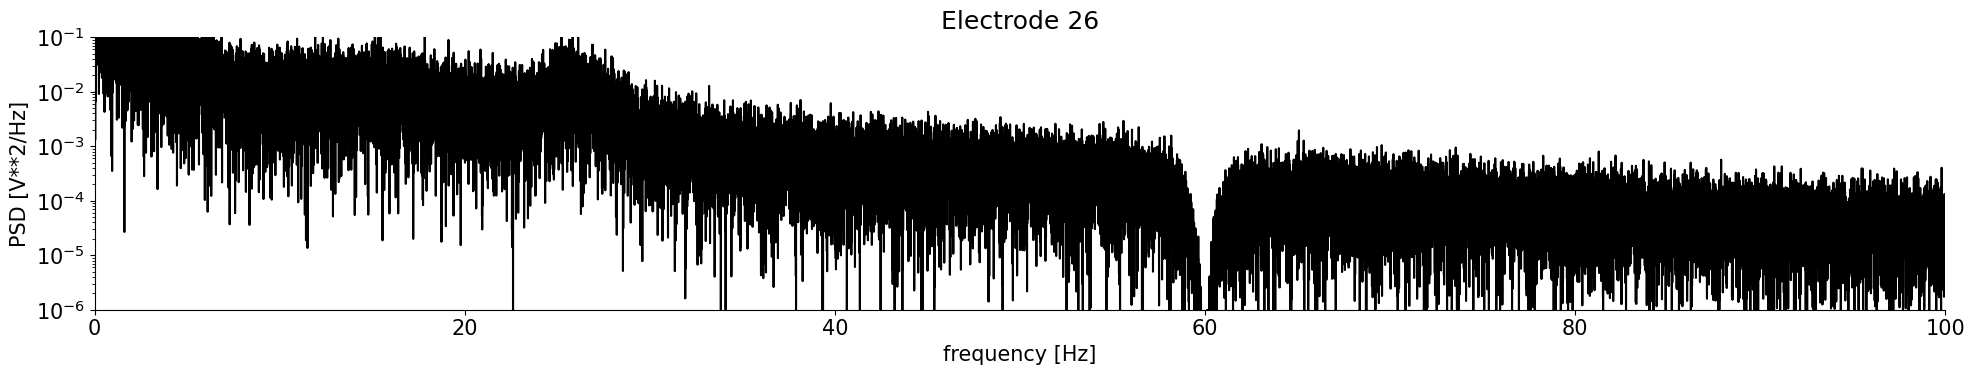

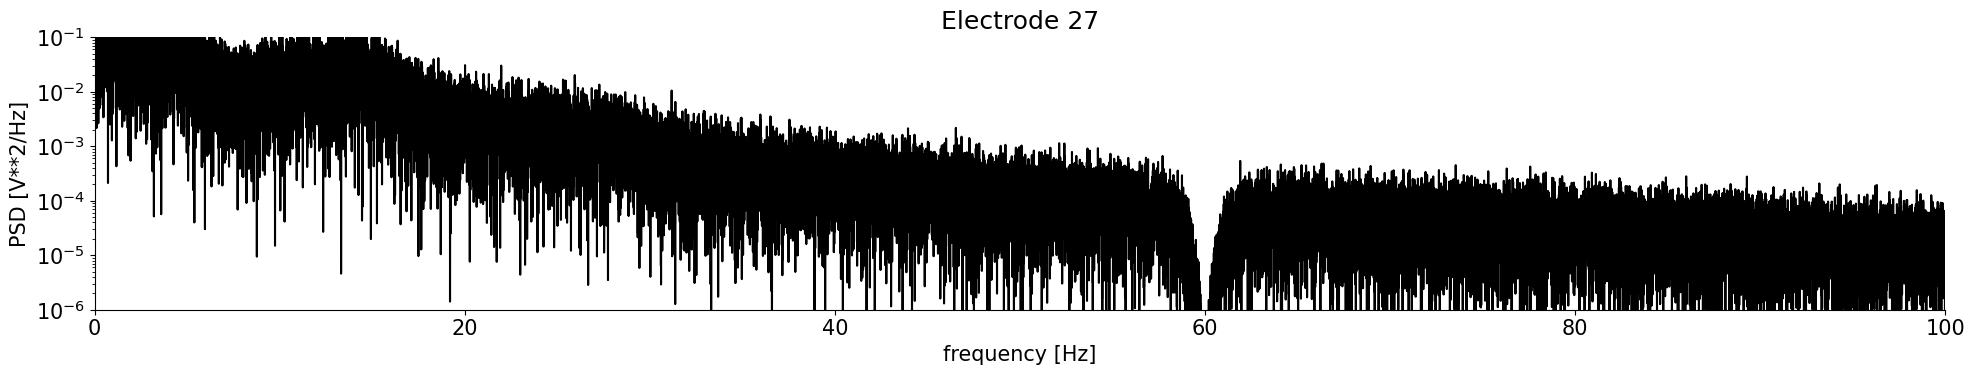

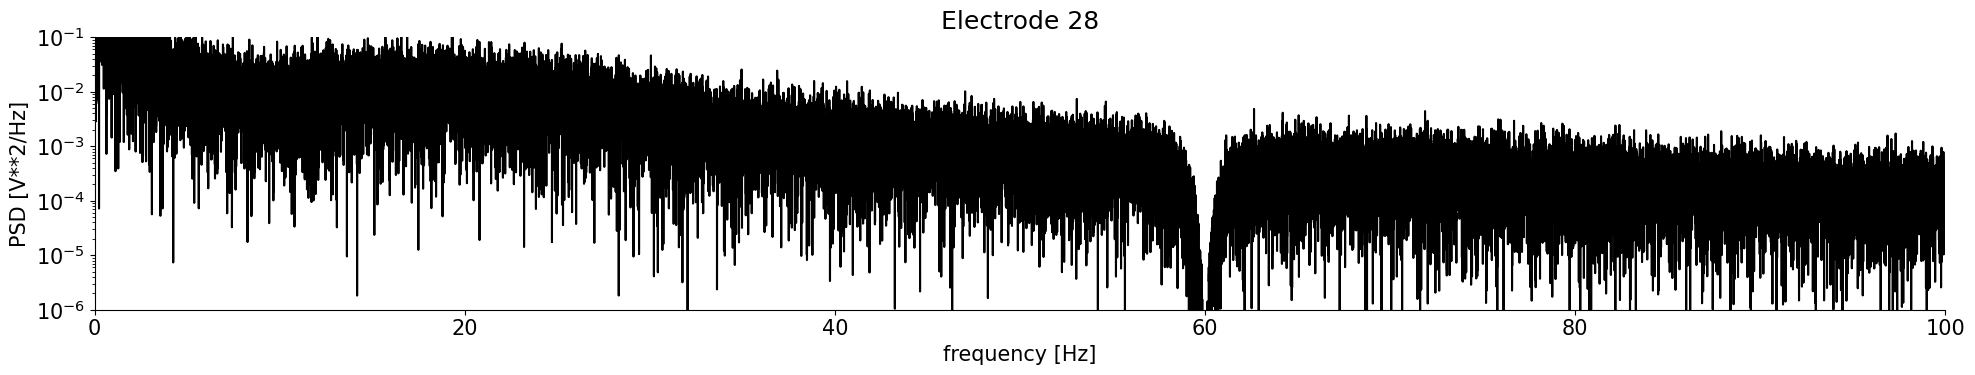

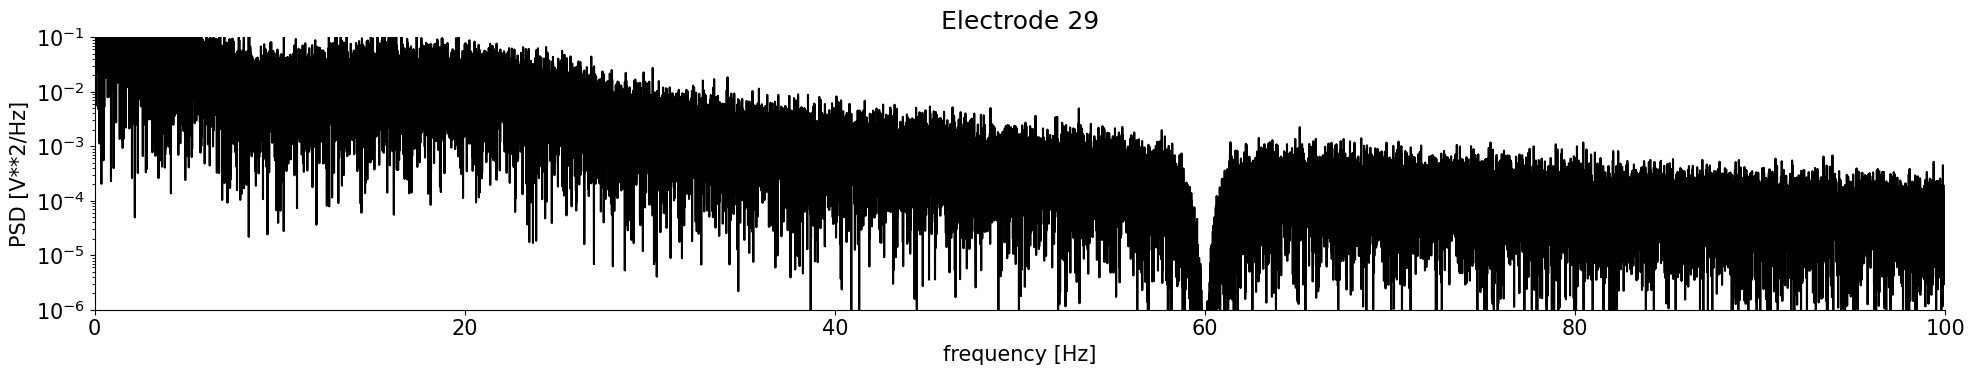

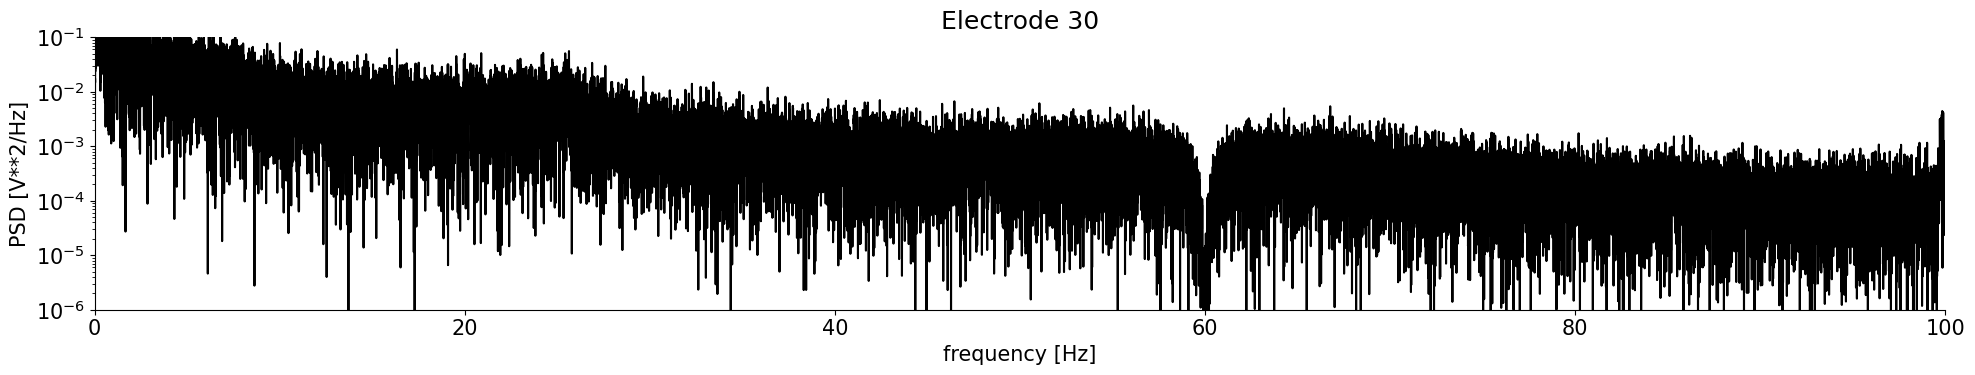

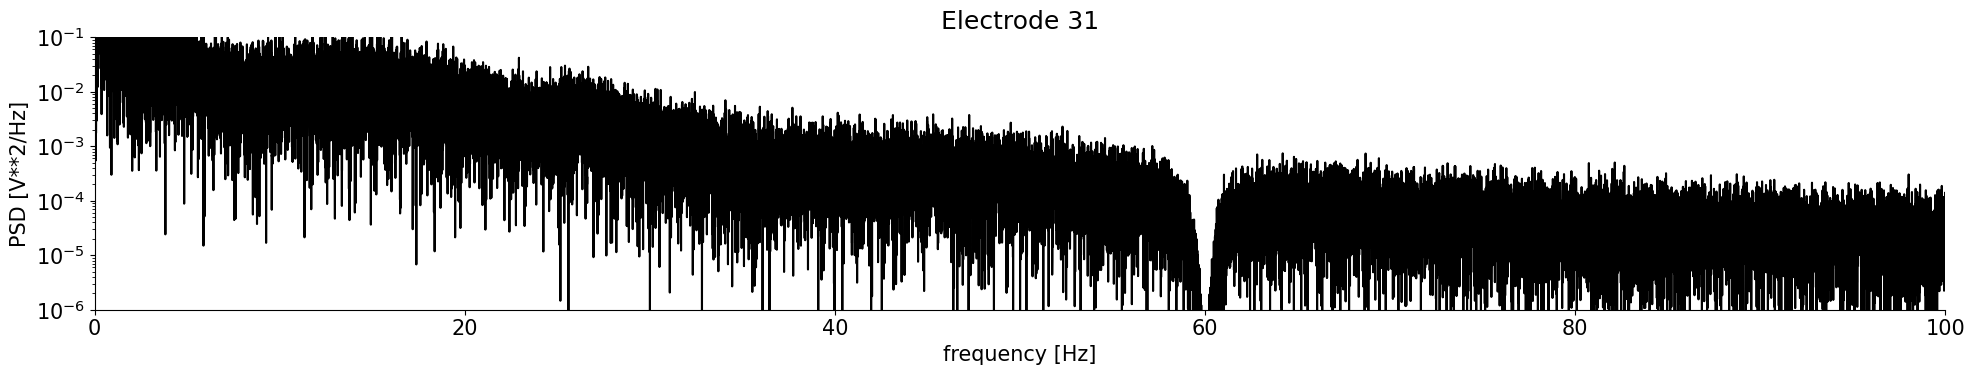

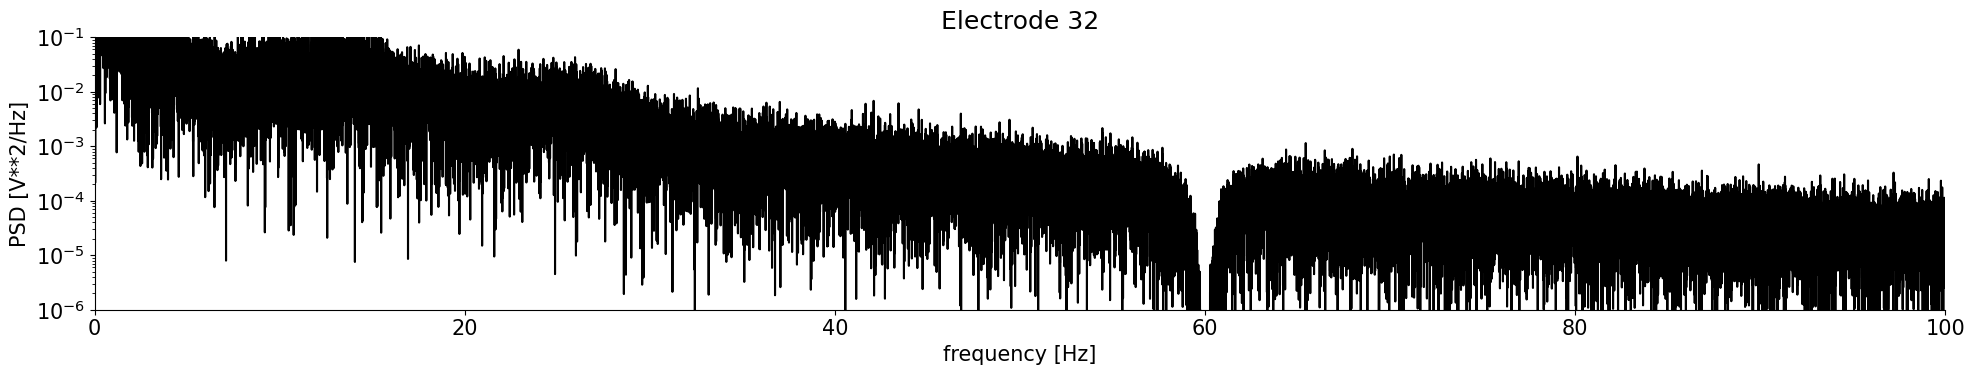

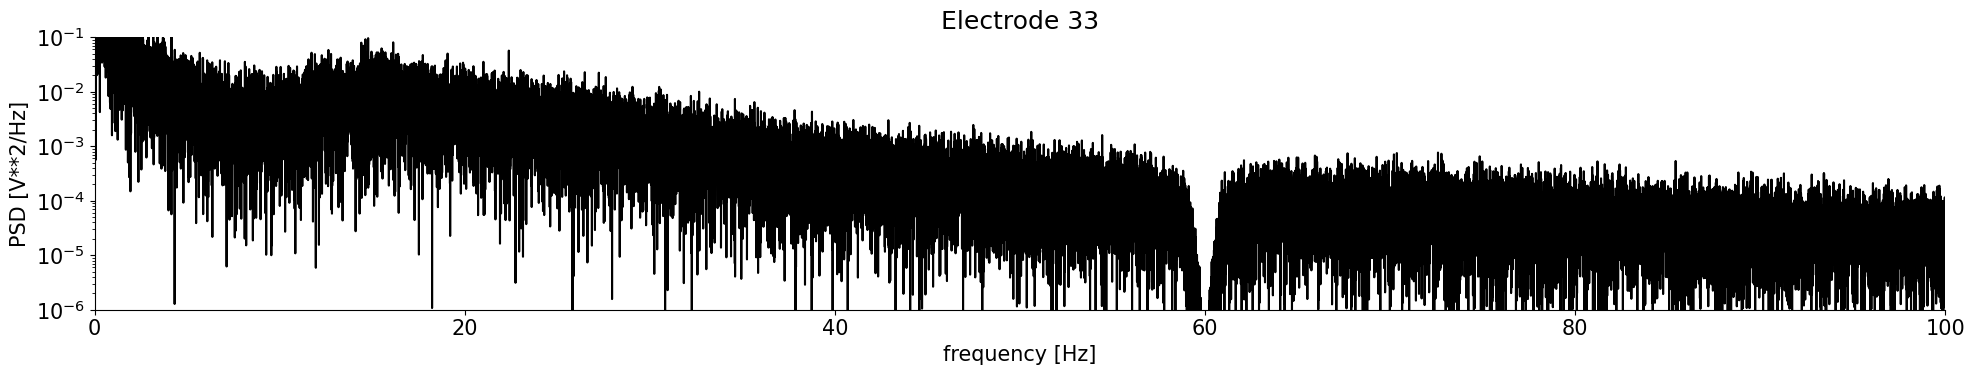

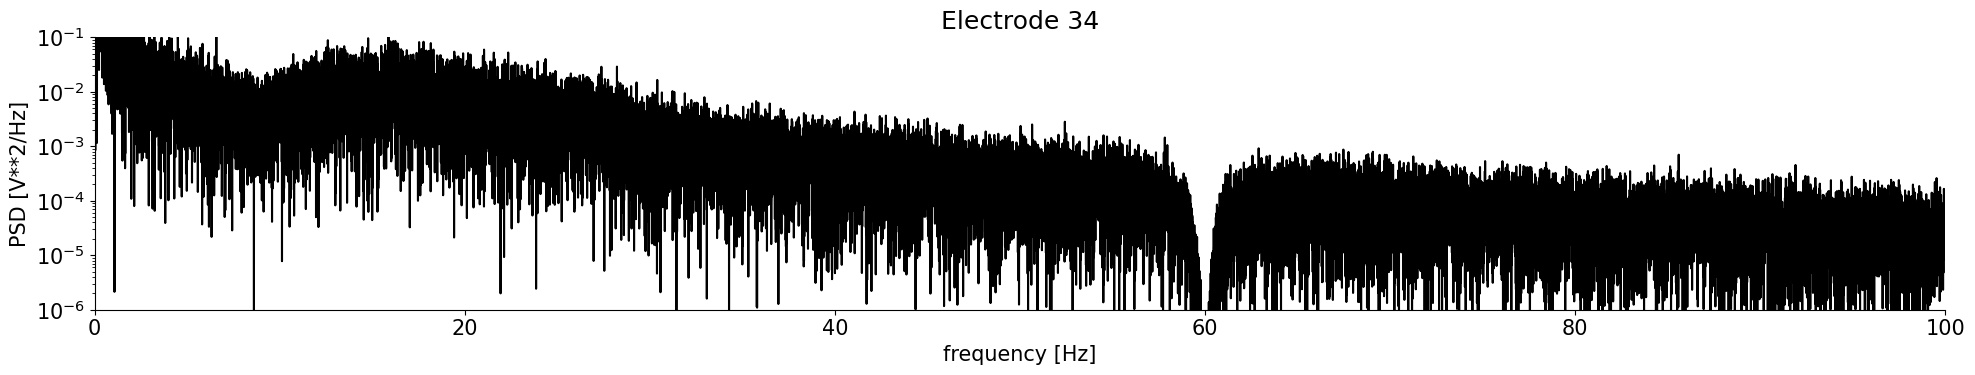

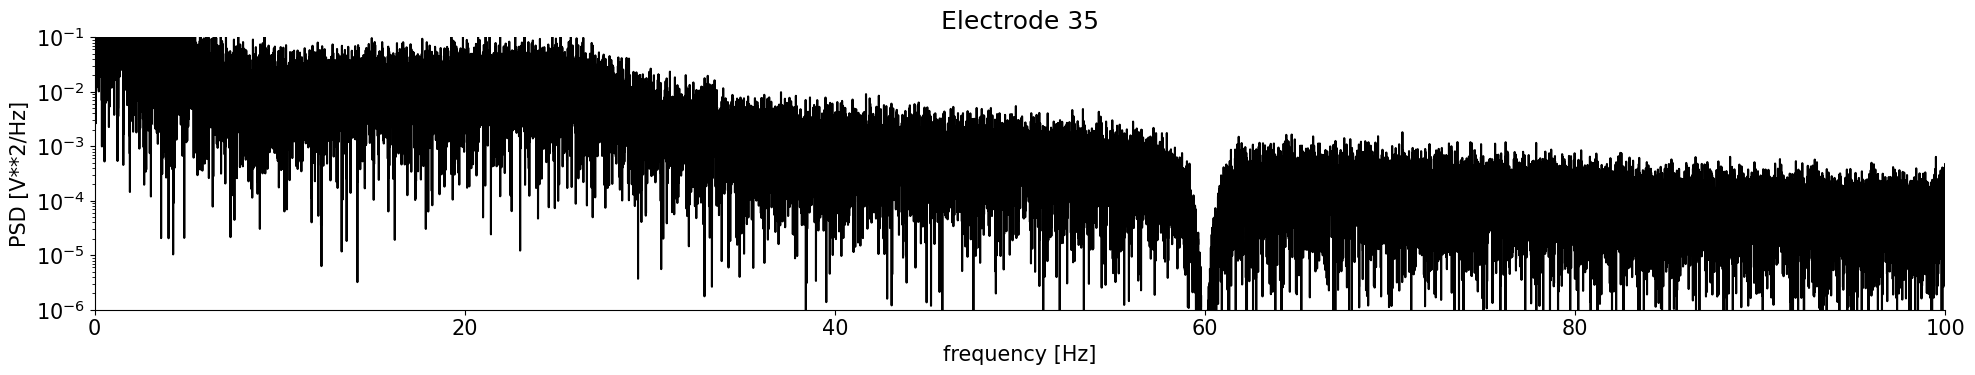

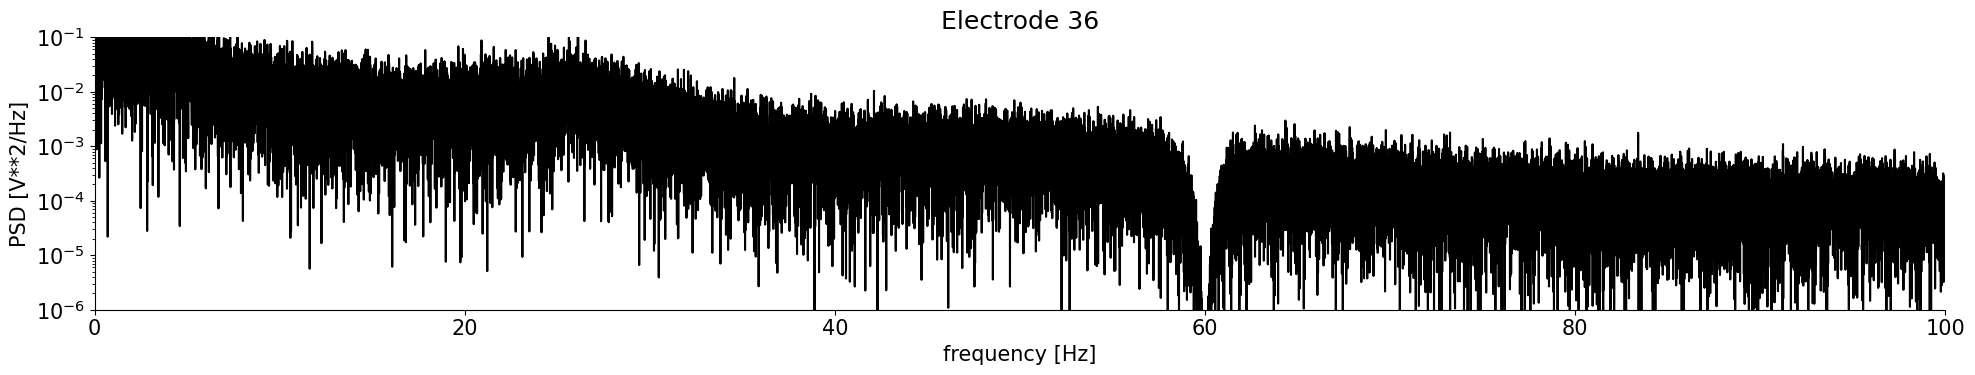

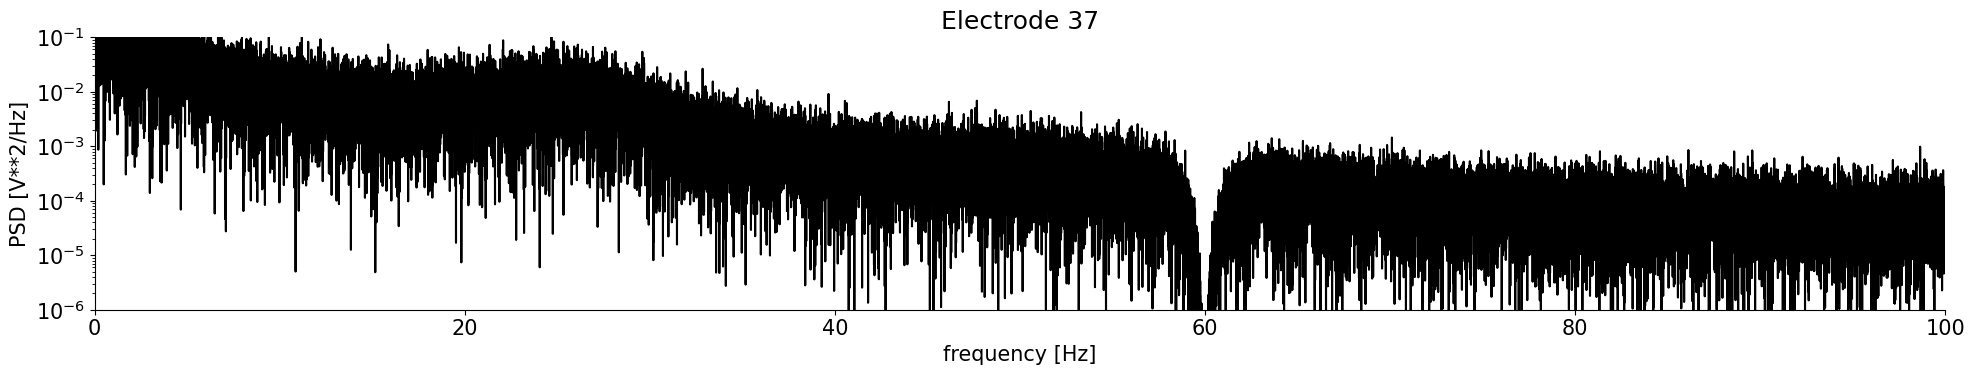

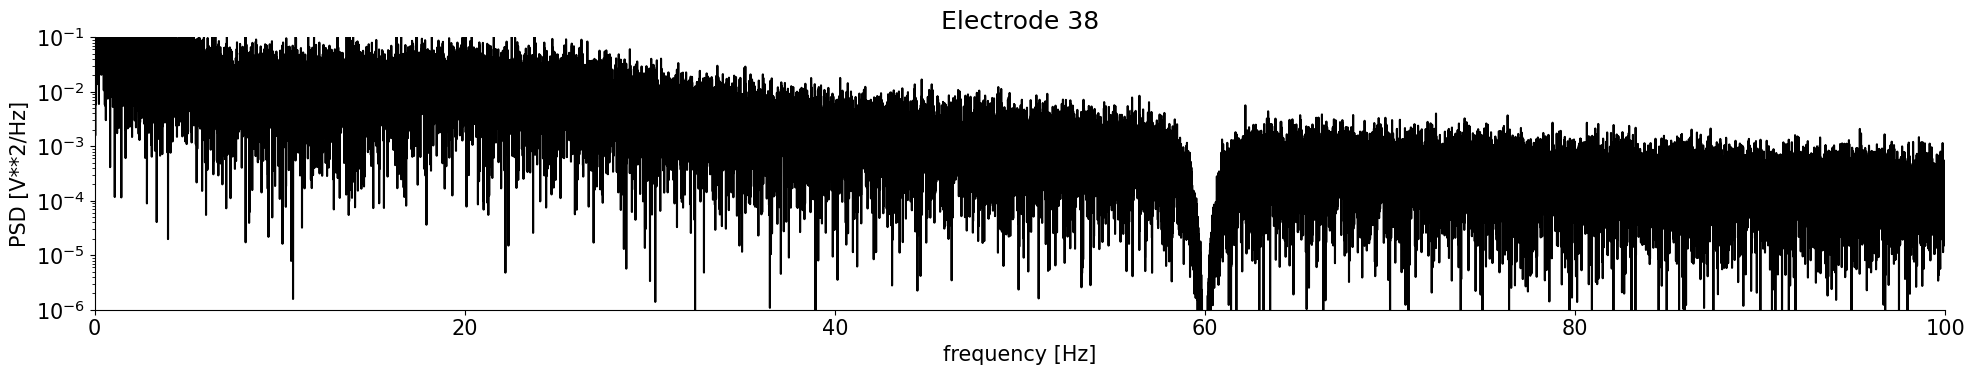

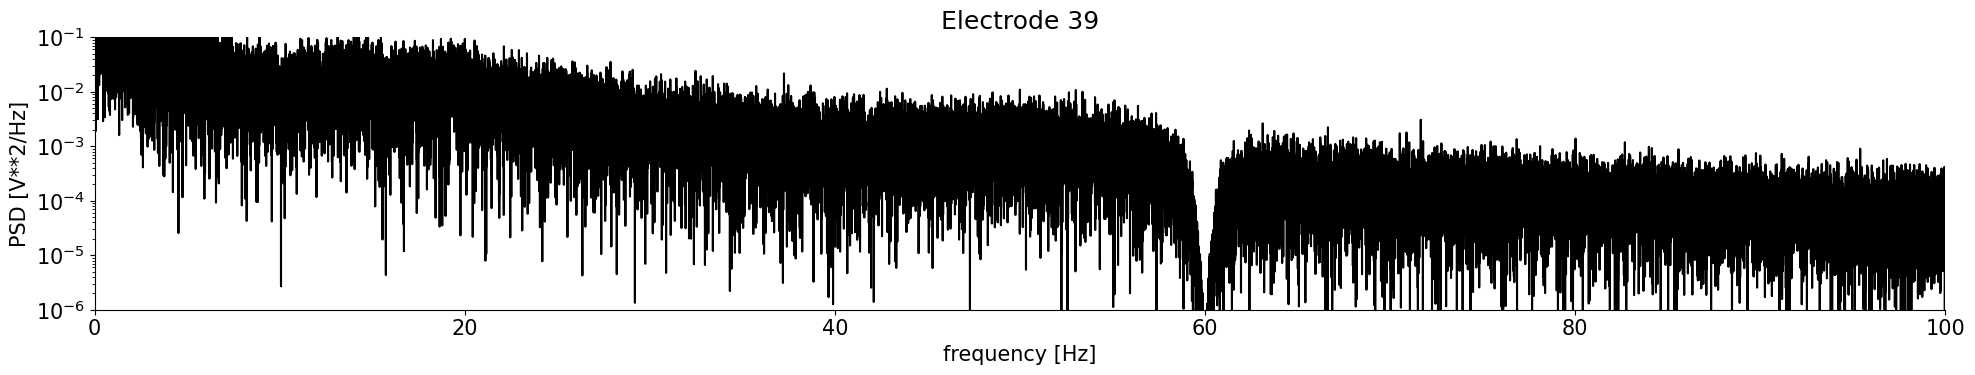

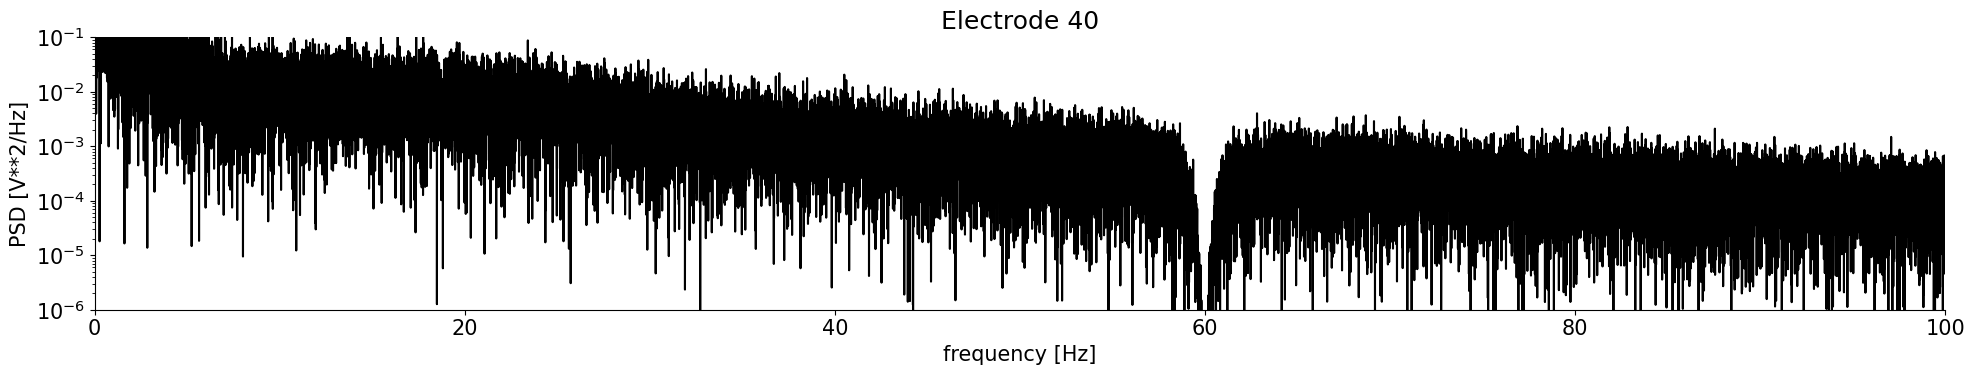

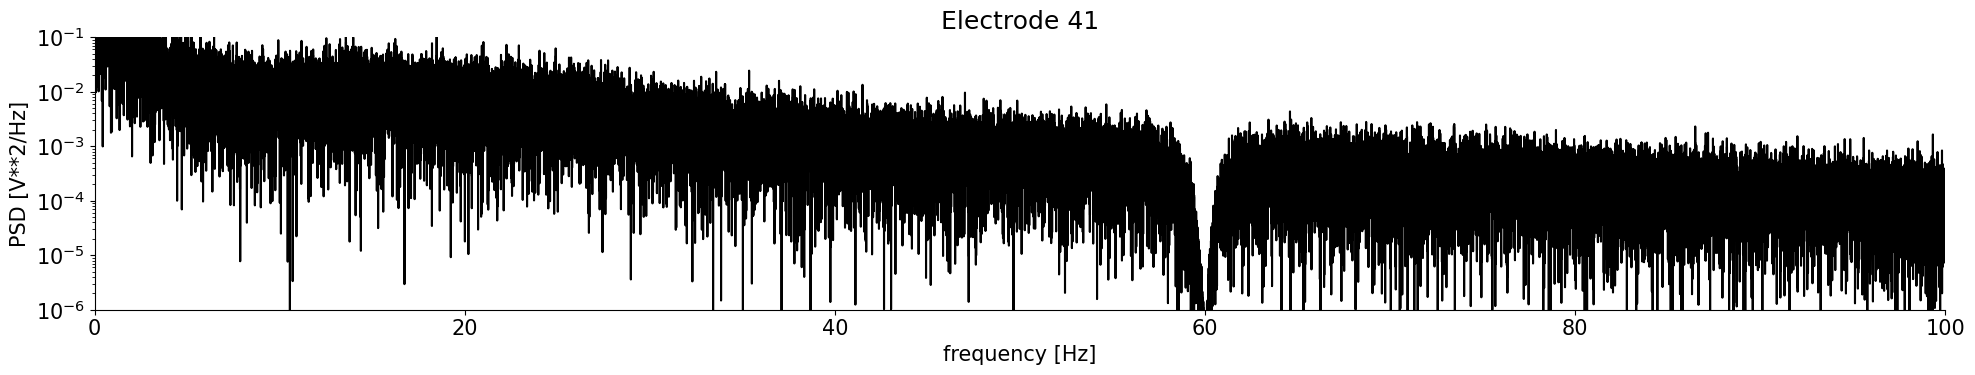

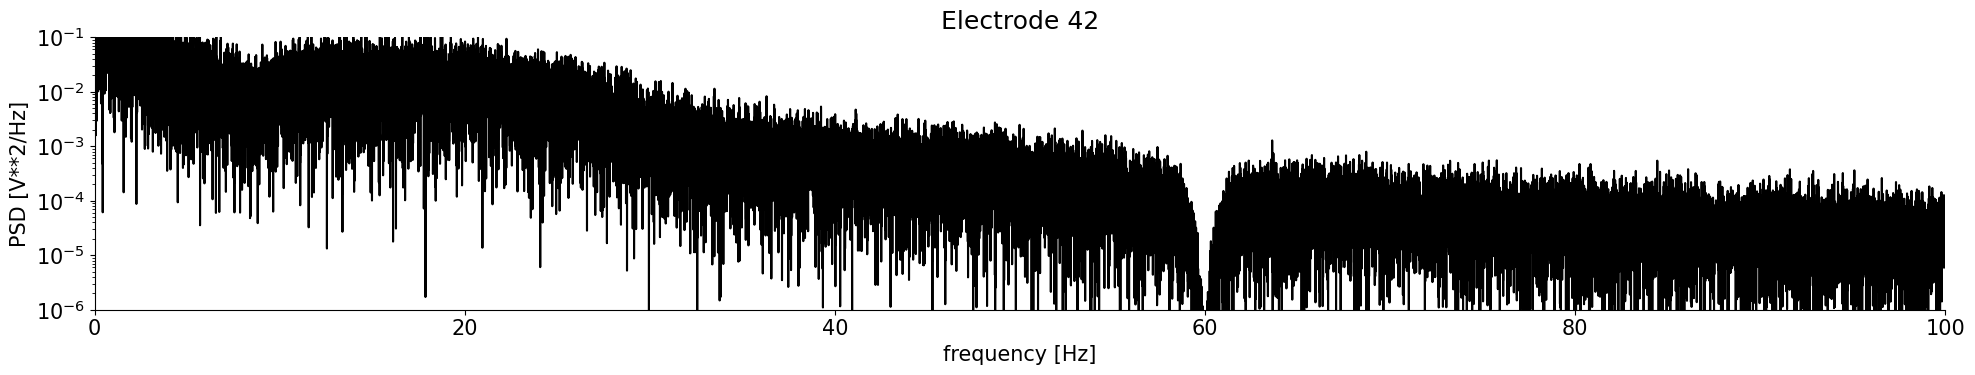

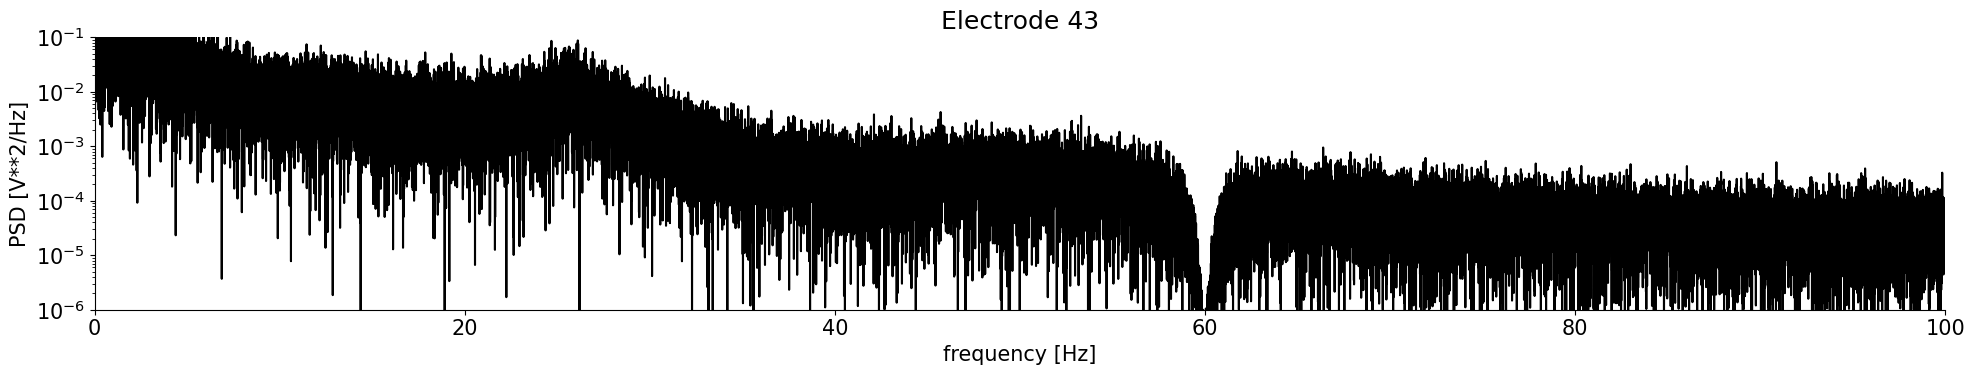

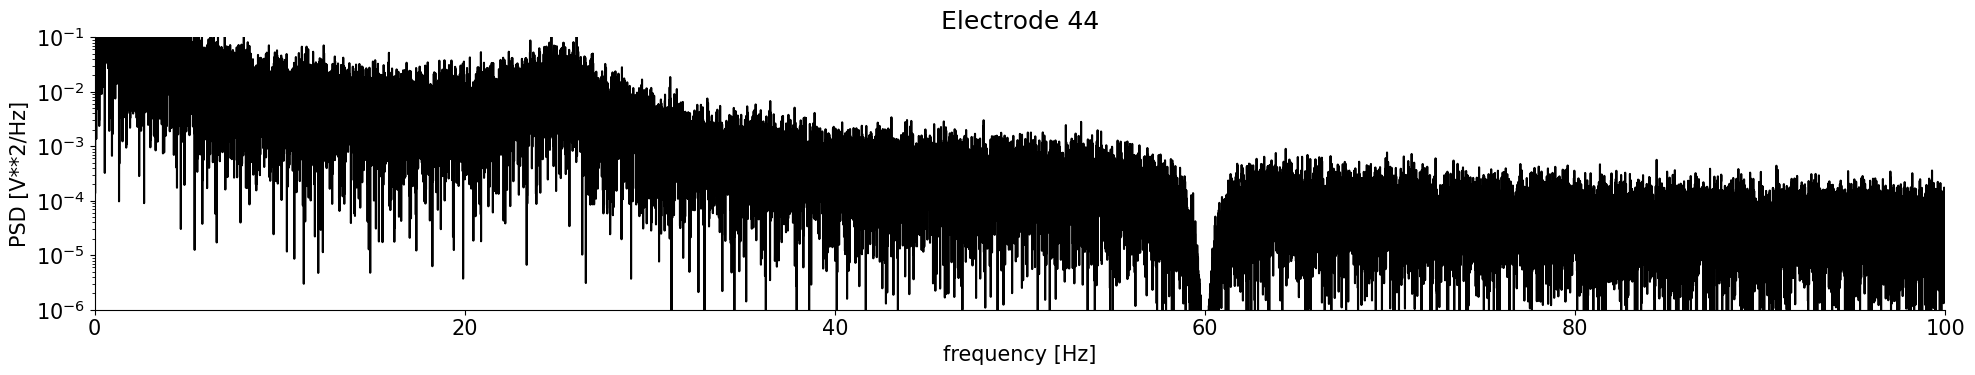

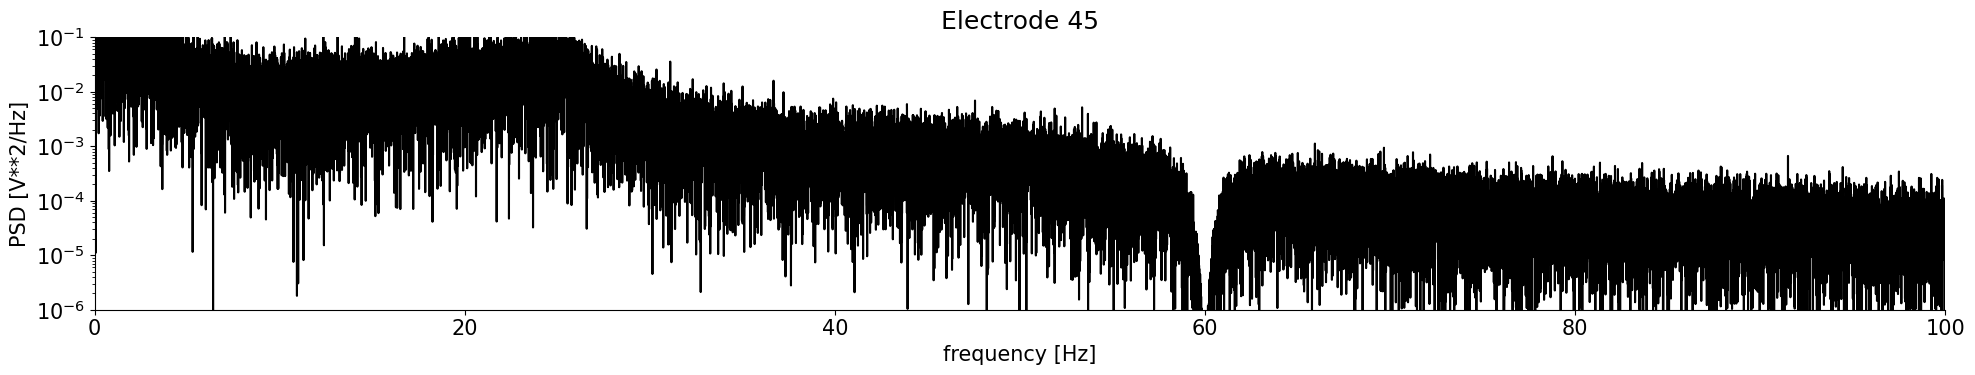

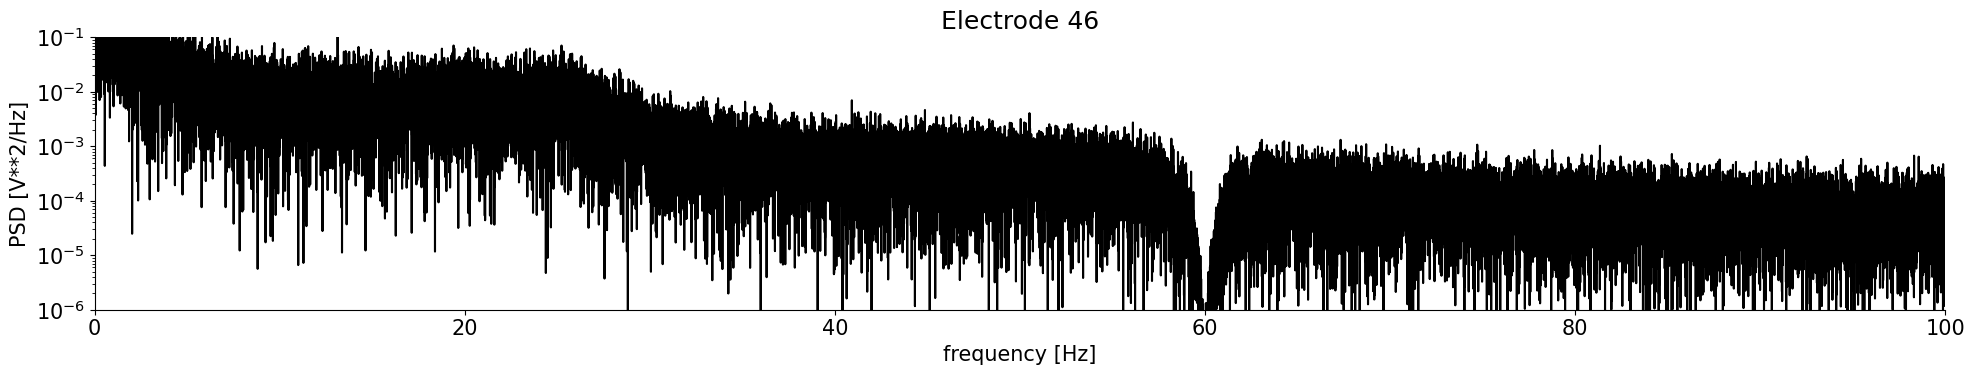

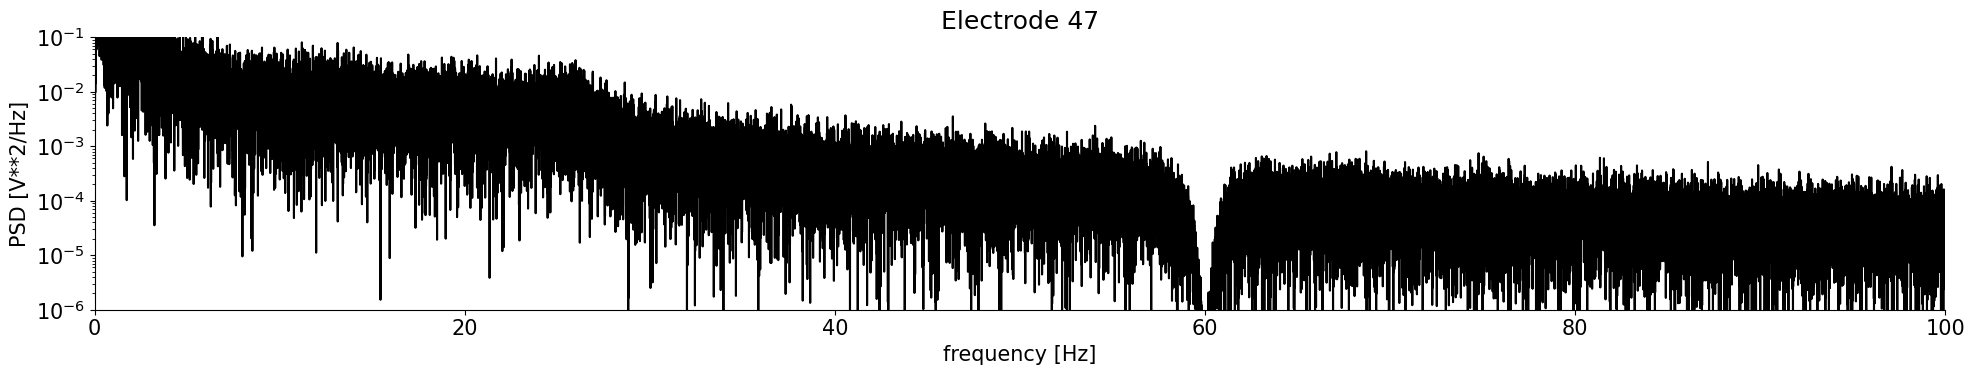

In [11]:
# PLOT separate power spectra for each electrode
plt.figure(figsize=(20, 4))
for j in range(nchan):
    f, Pxx = signal.periodogram(V[:, j], 1000)
    plt.semilogy(f, Pxx, 'k')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim([0, 100])
    plt.ylim([1e-6, 1e-1])
    plt.title('Electrode %d'%j)
    plt.show()    

Creating RawArray with float64 data, n_channels=64, n_times=134360
    Range : 0 ... 134359 =      0.000 ...   134.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.5s finished


Effective window size : 2.048 (s)


C:\Users\sdevl\AppData\Local\Temp\ipykernel_16320\2808211047.py:24: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=200, picks=np.arange(63), average=False)
c:\Users\sdevl\anaconda3\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


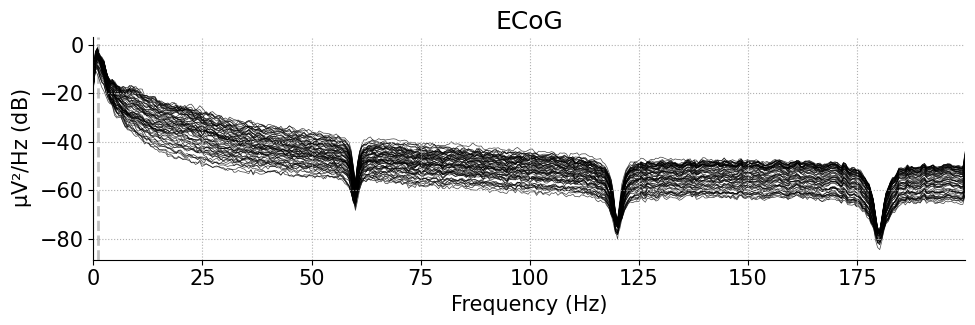

In [25]:
## Trial code - did not work properly to plot power spectrum of each electrode separately

# Plot power spectrum of all electrodes using mne

import mne
from scipy import signal

# convert to Volts
V = V * 1e-6

# create mne object
info = mne.create_info(nchan, 1000., 'ecog')
raw = mne.io.RawArray(V.T, info)

# filter data
raw.filter(1, 200)

# plot power spectrum
#raw.plot_psd(fmax=200, average=False)


# correct the following for ValueError: len(data) (1) does not match len(info["ch_names"])
#raw.plot_psd(fmax=200, picks=np.arange(nchan), average=False)

# plot power spectrum of each electrode separately
raw.plot_psd(fmax=200, picks=np.arange(63), average=False)

#make a for loop to plot power spectrum of 64 channels
#for j in range(nchan):
#    raw.plot_psd(fmax=200, picks=np.arange(j), average=False)


#plot power spectrum of each electrode separately

#for j in range(nchan):

#    f, Pxx = signal.periodogram(V[:, j], 1000)





# # plot power spectrum of each electrode separately
#for j in range(nchan):
#    raw.plot_psd(fmax=200, picks=np.arange(j), average=False)
    
# # plot power spectrum of each electrode separately
# for j in range(nchan):
    
#     f, Pxx = signal.periodogram(V[:, j], 1000)
#     plt.semilogy(f, Pxx, 'k')
#     plt.xlabel('frequency [Hz]')
#     plt.ylabel('PSD [V**2/Hz]')
#     plt.xlim([0, 100])
#     plt.ylim([1e-6, 1e-1])
#     plt.title('Electrode %d'%j)
#     plt.show()
    
    
    
    
    
    
#raw.plot_psd(fmax=200, picks=np.arange(nchan), average=False)






    
    

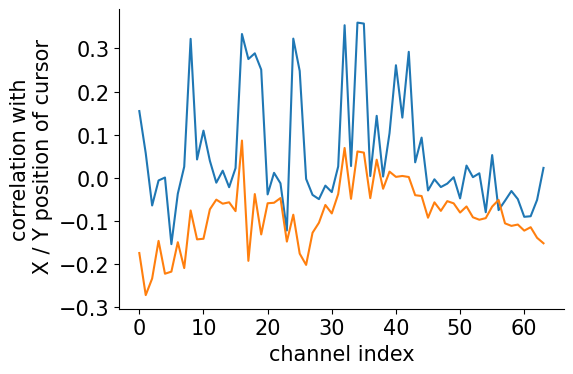

In [18]:
plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of cursor')
plt.xlabel('channel index')
plt.show()

In [ ]:
# this one needs a lot more plots!
# for some reason, I only see meaningful correlations in subjects 2 and 3,
# but it's possible that there is spectral information that is more useful in those subjects